In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

data_path = '/home/pratyush/additional_work/Images'
dataset = datasets.ImageFolder(root=data_path, transform=transform)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(seed)
)

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True if torch.cuda.is_available() else False)

In [4]:
class HierarchicalVAE(nn.Module):
    def __init__(self, latent_dim1=64, latent_dim2=32):
        super(HierarchicalVAE, self).__init__()
        self.latent_dim1 = latent_dim1  
        self.latent_dim2 = latent_dim2  
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),     
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),    
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),   
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),  
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),  
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.flatten = nn.Flatten()
        self.fc_mu2 = nn.Linear(512 * 8 * 8, latent_dim2)
        self.fc_logvar2 = nn.Linear(512 * 8 * 8, latent_dim2)
        
        self.fc_mu1 = nn.Linear(latent_dim2, latent_dim1)
        self.fc_logvar1 = nn.Linear(latent_dim2, latent_dim1)
        
        self.fc_z1_to_z2_mu = nn.Linear(latent_dim1, latent_dim2)
        self.fc_z1_to_z2_logvar = nn.Linear(latent_dim1, latent_dim2)
        
        self.decoder_input = nn.Linear(latent_dim1, 512 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     
            nn.Sigmoid()
        )

    def encode_to_z2(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu2 = self.fc_mu2(x)
        logvar2 = self.fc_logvar2(x)
        # Clamp values for stability
        logvar2 = torch.clamp(logvar2, min=-20, max=20)
        return mu2, logvar2
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        std = torch.clamp(std, min=1e-5)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode_z2_to_z1(self, z2):
        mu1 = self.fc_mu1(z2)
        logvar1 = self.fc_logvar1(z2)
        logvar1 = torch.clamp(logvar1, min=-20, max=20)
        return mu1, logvar1
    
    def decode_z1_to_z2(self, z1):
        mu_z2 = self.fc_z1_to_z2_mu(z1)
        logvar_z2 = self.fc_z1_to_z2_logvar(z1)
        logvar_z2 = torch.clamp(logvar_z2, min=-20, max=20)
        return mu_z2, logvar_z2
    
    def decode(self, z1):
        x = self.decoder_input(z1)
        x = x.view(-1, 512, 8, 8)
        return self.decoder(x)
    
    def forward(self, x):
        mu2, logvar2 = self.encode_to_z2(x)
        z2 = self.reparameterize(mu2, logvar2)
        mu1, logvar1 = self.encode_z2_to_z1(z2)
        z1 = self.reparameterize(mu1, logvar1)
        mu_z2_decoded, logvar_z2_decoded = self.decode_z1_to_z2(z1)
        recon_x = self.decode(z1)
        return recon_x, mu1, logvar1, mu2, logvar2, mu_z2_decoded, logvar_z2_decoded
    
    def sample(self, num_samples=1, device='cuda'):
        z1 = torch.randn(num_samples, self.latent_dim1).to(device)
        return self.decode(z1)

In [5]:
def loss_function(recon_x, x, mu1, logvar1, mu2, logvar2, mu_z2_decoded, logvar_z2_decoded):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div1 = -0.5 * torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp())
    var2 = torch.exp(logvar2)
    var_z2_decoded = torch.exp(logvar_z2_decoded)
    kl_div2 = 0.5 * torch.sum(logvar_z2_decoded - logvar2 + (var2 + (mu2 - mu_z2_decoded).pow(2)) / (var_z2_decoded + 1e-10) - 1)
    kl_div1 = torch.clamp(kl_div1, max=1000)
    kl_div2 = torch.clamp(kl_div2, max=1000)
    return recon_loss, kl_div1*10, kl_div2*10

In [6]:
def train_epoch(model, train_loader, optimizer, device, beta1=1, beta2=1, grad_clip=1.0):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl1_loss_total = 0
    kl2_loss_total = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc="Training")):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu1, logvar1, mu2, logvar2, mu_z2_decoded, logvar_z2_decoded = model(data)
        recon_loss, kl1, kl2 = loss_function(recon_batch, data, mu1, logvar1, mu2, logvar2, mu_z2_decoded, logvar_z2_decoded)
        
        loss = recon_loss + beta1 * kl1 + beta2 * kl2
        if torch.isnan(loss):
            print("Warning: NaN detected in loss. Skipping batch.")
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl1_loss_total += kl1.item()
        kl2_loss_total += kl2.item()
    
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl1 = kl1_loss_total / len(train_loader.dataset)
    avg_kl2 = kl2_loss_total / len(train_loader.dataset)
    
    return avg_loss, avg_recon, avg_kl1, avg_kl2

def validate(model, val_loader, device, beta1=0.1, beta2=0.1):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl1_loss_total = 0
    kl2_loss_total = 0
    
    with torch.no_grad():
        for data, _ in tqdm(val_loader, desc="Validation"):
            data = data.to(device)
            
            recon_batch, mu1, logvar1, mu2, logvar2, mu_z2_decoded, logvar_z2_decoded = model(data)
            recon_loss, kl1, kl2 = loss_function(recon_batch, data, mu1, logvar1, mu2, logvar2, mu_z2_decoded, logvar_z2_decoded)
            loss = recon_loss + beta1 * kl1 + beta2 * kl2
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl1_loss_total += kl1.item()
            kl2_loss_total += kl2.item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl1 = kl1_loss_total / len(val_loader.dataset)
    avg_kl2 = kl2_loss_total / len(val_loader.dataset)
    
    return avg_loss, avg_recon, avg_kl1, avg_kl2

In [7]:
def train_model(model, train_loader, val_loader, device, epochs=500, lr=1e-4, early_stopping_patience=30, scheduler_patience=6, scheduler_factor=0.9):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True)
    
    train_losses = []
    val_losses = []
    train_recon_losses = []
    val_recon_losses = []
    train_kl1_losses = []
    val_kl1_losses = []
    train_kl2_losses = []
    val_kl2_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    start_time = time.time()
    
    beta1_start, beta1_end = 0.0, 1.0
    beta2_start, beta2_end = 0.0, 1.0
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        ramp_epochs = min(500, epochs)
        
        beta1 = min(beta1_start + (beta1_end - beta1_start) * epoch / ramp_epochs, beta1_end)
        beta2 = min(beta2_start + (beta2_end - beta2_start) * epoch / ramp_epochs, beta2_end)
        print(f"Current beta values: beta1={beta1:.4f}, beta2={beta2:.4f}")
        
        train_loss, train_recon, train_kl1, train_kl2 = train_epoch(
            model, train_loader, optimizer, device, beta1, beta2, grad_clip=5.0)
        val_loss, val_recon, val_kl1, val_kl2 = validate(
            model, val_loader, device, beta1, beta2)
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_recon_losses.append(train_recon)
        val_recon_losses.append(val_recon)
        train_kl1_losses.append(train_kl1)
        val_kl1_losses.append(val_kl1)
        train_kl2_losses.append(train_kl2)
        val_kl2_losses.append(val_kl2)
        
        print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        print(f"Train Recon: {train_recon:.6f}, KL1: {train_kl1:.6f}, KL2: {train_kl2:.6f}")
        print(f"Val Recon: {val_recon:.6f}, KL1: {val_kl1:.6f}, KL2: {val_kl2:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"New best validation loss: {best_val_loss:.6f}")
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, f'hvae_checkpoint_epoch_{epoch}.pth')
            
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
            
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping after {epoch} epochs")
                break
        
        if epoch % 30 == 0 or epoch == 1:
            visualize_reconstructions(model, val_loader, device)
    
    time_elapsed = time.time() - start_time

    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(train_recon_losses, label='Train Recon Loss')
    plt.plot(val_recon_losses, label='Val Recon Loss')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(train_kl1_losses, label='Train KL1 Loss')
    plt.plot(val_kl1_losses, label='Val KL1 Loss')
    plt.title('KL Divergence Loss (z1)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(train_kl2_losses, label='Train KL2 Loss')
    plt.plot(val_kl2_losses, label='Val KL2 Loss')
    plt.title('KL Divergence Loss (z2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_losses.png')
    plt.show()
    
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_recon_losses': train_recon_losses,
        'val_recon_losses': val_recon_losses,
        'train_kl1_losses': train_kl1_losses,
        'val_kl1_losses': val_kl1_losses,
        'train_kl2_losses': train_kl2_losses,
        'val_kl2_losses': val_kl2_losses
    }

In [8]:
def visualize_reconstructions(model, data_loader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(data_loader))
        data = data.to(device)
        recon, *_ = model(data)
        
        fig, axes = plt.subplots(2, 1, figsize=(12, 6))
        axes[0].imshow(vutils.make_grid(data[:num_images].cpu(), nrow=num_images, normalize=True).permute(1, 2, 0))
        axes[0].set_title("Original Images")
        axes[0].axis("off")
        
        axes[1].imshow(vutils.make_grid(recon[:num_images].cpu(), nrow=num_images, normalize=True).permute(1, 2, 0))
        axes[1].set_title("Reconstructed Images")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.savefig(f'reconstruction_{time.time()}.png')
        plt.show()    

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = HierarchicalVAE(latent_dim1=32, latent_dim2=16).to(device)
print(model)

Using device: cuda
HierarchicalVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
  

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 7,710,083


/home/pratyush/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/1000
Current beta values: beta1=0.0020, beta2=0.0020


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.54it/s]


Train Loss: 8564.947045, Val Loss: 9102.914881
Train Recon: 8563.712330, KL1: 308.347927, KL2: 309.009588
Val Recon: 9101.581548, KL1: 333.333333, KL2: 333.333333
New best validation loss: 9102.914881


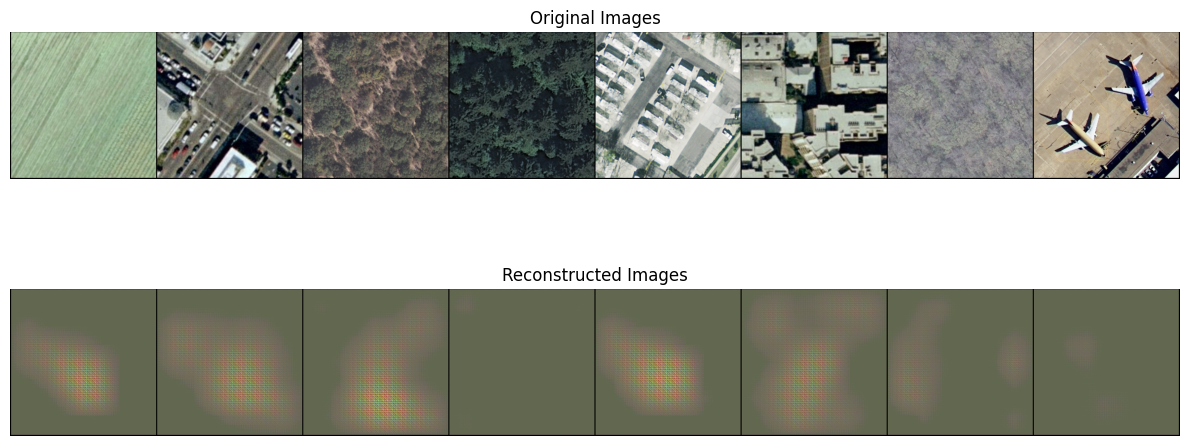


Epoch 2/1000
Current beta values: beta1=0.0040, beta2=0.0040


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.84it/s]


Train Loss: 8270.010013, Val Loss: 8992.590179
Train Recon: 8267.506611, KL1: 312.925170, KL2: 312.925170
Val Recon: 8989.923512, KL1: 333.333333, KL2: 333.333333
New best validation loss: 8992.590179

Epoch 3/1000
Current beta values: beta1=0.0060, beta2=0.0060


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


Train Loss: 8251.991794, Val Loss: 8991.878199
Train Recon: 8248.236692, KL1: 312.925170, KL2: 312.925170
Val Recon: 8987.878199, KL1: 333.333333, KL2: 333.333333
New best validation loss: 8991.878199

Epoch 4/1000
Current beta values: beta1=0.0080, beta2=0.0080


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.23it/s]


Train Loss: 8237.788340, Val Loss: 8997.044978
Train Recon: 8232.781537, KL1: 312.925170, KL2: 312.925170
Val Recon: 8991.711644, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 5/1000
Current beta values: beta1=0.0100, beta2=0.0100


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


Train Loss: 8235.980421, Val Loss: 8998.099256
Train Recon: 8229.721918, KL1: 312.925170, KL2: 312.925170
Val Recon: 8991.432589, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 6/1000
Current beta values: beta1=0.0120, beta2=0.0120


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.70it/s]


Train Loss: 8235.012691, Val Loss: 9038.979539
Train Recon: 8227.502487, KL1: 312.925170, KL2: 312.925170
Val Recon: 9030.979539, KL1: 333.333333, KL2: 333.333333
No improvement for 3 epochs

Epoch 7/1000
Current beta values: beta1=0.0140, beta2=0.0140


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.13it/s]


Train Loss: 8138.772789, Val Loss: 8810.999888
Train Recon: 8130.010884, KL1: 312.925170, KL2: 312.925170
Val Recon: 8801.666555, KL1: 333.333333, KL2: 333.333333
New best validation loss: 8810.999888

Epoch 8/1000
Current beta values: beta1=0.0160, beta2=0.0160


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.28it/s]


Train Loss: 7779.895355, Val Loss: 8350.651711
Train Recon: 7769.881750, KL1: 312.925170, KL2: 312.925170
Val Recon: 8339.985045, KL1: 333.333333, KL2: 333.333333
New best validation loss: 8350.651711

Epoch 9/1000
Current beta values: beta1=0.0180, beta2=0.0180


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.39it/s]


Train Loss: 7490.616210, Val Loss: 7997.242597
Train Recon: 7479.350903, KL1: 312.925170, KL2: 312.925170
Val Recon: 7985.242597, KL1: 333.333333, KL2: 333.333333
New best validation loss: 7997.242597

Epoch 10/1000
Current beta values: beta1=0.0200, beta2=0.0200


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.65it/s]


Train Loss: 7395.159758, Val Loss: 7868.828943
Train Recon: 7382.642751, KL1: 312.925170, KL2: 312.925170
Val Recon: 7855.495610, KL1: 333.333333, KL2: 333.333333
New best validation loss: 7868.828943

Epoch 11/1000
Current beta values: beta1=0.0220, beta2=0.0220


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


Train Loss: 7254.544515, Val Loss: 7467.627753
Train Recon: 7240.775808, KL1: 312.925170, KL2: 312.925170
Val Recon: 7452.961086, KL1: 333.333333, KL2: 333.333333
New best validation loss: 7467.627753

Epoch 12/1000
Current beta values: beta1=0.0240, beta2=0.0240


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


Train Loss: 6767.024107, Val Loss: 6966.285454
Train Recon: 6752.003699, KL1: 312.925170, KL2: 312.925170
Val Recon: 6950.285454, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6966.285454

Epoch 13/1000
Current beta values: beta1=0.0260, beta2=0.0260


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.64it/s]


Train Loss: 6475.258036, Val Loss: 6781.888728
Train Recon: 6458.985927, KL1: 312.925170, KL2: 312.925170
Val Recon: 6764.555394, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6781.888728

Epoch 14/1000
Current beta values: beta1=0.0280, beta2=0.0280


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.52it/s]


Train Loss: 6363.139328, Val Loss: 6765.556436
Train Recon: 6345.615519, KL1: 312.925170, KL2: 312.925170
Val Recon: 6746.889769, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6765.556436

Epoch 15/1000
Current beta values: beta1=0.0300, beta2=0.0300


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.01it/s]


Train Loss: 6424.858046, Val Loss: 6886.465476
Train Recon: 6406.082536, KL1: 312.925170, KL2: 312.925170
Val Recon: 6866.465476, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 16/1000
Current beta values: beta1=0.0320, beta2=0.0320


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.12it/s]


Train Loss: 6358.137585, Val Loss: 6773.170313
Train Recon: 6338.110374, KL1: 312.925170, KL2: 312.925170
Val Recon: 6751.836979, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 17/1000
Current beta values: beta1=0.0340, beta2=0.0340


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.79it/s]


Train Loss: 6333.296088, Val Loss: 6708.605915
Train Recon: 6312.017177, KL1: 312.925170, KL2: 312.925170
Val Recon: 6685.939249, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6708.605915

Epoch 18/1000
Current beta values: beta1=0.0360, beta2=0.0360


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.38it/s]


Train Loss: 6332.921078, Val Loss: 6698.929241
Train Recon: 6310.390466, KL1: 312.925170, KL2: 312.925170
Val Recon: 6674.929241, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6698.929241

Epoch 19/1000
Current beta values: beta1=0.0380, beta2=0.0380


Validation: 100%|██████████| 7/7 [00:00<00:00, 23.31it/s]


Train Loss: 6327.517102, Val Loss: 6708.545201
Train Recon: 6303.734790, KL1: 312.925170, KL2: 312.925170
Val Recon: 6683.211868, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 20/1000
Current beta values: beta1=0.0400, beta2=0.0400


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.69it/s]


Train Loss: 6393.636310, Val Loss: 6925.219792
Train Recon: 6368.602296, KL1: 312.925170, KL2: 312.925170
Val Recon: 6898.553125, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 21/1000
Current beta values: beta1=0.0420, beta2=0.0420


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.99it/s]


Train Loss: 6433.079741, Val Loss: 6909.714435
Train Recon: 6406.794026, KL1: 312.925170, KL2: 312.925170
Val Recon: 6881.714435, KL1: 333.333333, KL2: 333.333333
No improvement for 3 epochs

Epoch 22/1000
Current beta values: beta1=0.0440, beta2=0.0440


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.32it/s]


Train Loss: 6400.916401, Val Loss: 6811.796280
Train Recon: 6373.378986, KL1: 312.925170, KL2: 312.925170
Val Recon: 6782.462946, KL1: 333.333333, KL2: 333.333333
No improvement for 4 epochs

Epoch 23/1000
Current beta values: beta1=0.0460, beta2=0.0460


Validation: 100%|██████████| 7/7 [00:00<00:00, 23.30it/s]


Train Loss: 6336.753465, Val Loss: 6743.821503
Train Recon: 6307.964349, KL1: 312.925170, KL2: 312.925170
Val Recon: 6713.154836, KL1: 333.333333, KL2: 333.333333
No improvement for 5 epochs

Epoch 24/1000
Current beta values: beta1=0.0480, beta2=0.0480


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


Train Loss: 6338.535597, Val Loss: 6713.426376
Train Recon: 6308.494781, KL1: 312.925170, KL2: 312.925170
Val Recon: 6681.426376, KL1: 333.333333, KL2: 333.333333
No improvement for 6 epochs

Epoch 25/1000
Current beta values: beta1=0.0500, beta2=0.0500


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.01it/s]


Train Loss: 6311.168973, Val Loss: 6734.191332
Train Recon: 6279.876456, KL1: 312.925170, KL2: 312.925170
Val Recon: 6700.857999, KL1: 333.333333, KL2: 333.333333
No improvement for 7 epochs

Epoch 26/1000
Current beta values: beta1=0.0520, beta2=0.0520


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.26it/s]


Train Loss: 6295.830219, Val Loss: 6741.604539
Train Recon: 6263.286001, KL1: 312.925170, KL2: 312.925170
Val Recon: 6706.937872, KL1: 333.333333, KL2: 333.333333
No improvement for 8 epochs

Epoch 27/1000
Current beta values: beta1=0.0540, beta2=0.0540


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.61it/s]


Train Loss: 6294.724787, Val Loss: 6705.277827
Train Recon: 6260.928869, KL1: 312.925170, KL2: 312.925170
Val Recon: 6669.277827, KL1: 333.333333, KL2: 333.333333
No improvement for 9 epochs

Epoch 28/1000
Current beta values: beta1=0.0560, beta2=0.0560


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


Train Loss: 6315.851456, Val Loss: 6705.582217
Train Recon: 6280.803837, KL1: 312.925170, KL2: 312.925170
Val Recon: 6668.248884, KL1: 333.333333, KL2: 333.333333
No improvement for 10 epochs

Epoch 29/1000
Current beta values: beta1=0.0580, beta2=0.0580


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.27it/s]


Train Loss: 6303.712277, Val Loss: 6742.541667
Train Recon: 6267.412957, KL1: 312.925170, KL2: 312.925170
Val Recon: 6703.875000, KL1: 333.333333, KL2: 333.333333
No improvement for 11 epochs

Epoch 30/1000
Current beta values: beta1=0.0600, beta2=0.0600


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.80it/s]


Train Loss: 6302.628720, Val Loss: 6690.190402
Train Recon: 6265.077700, KL1: 312.925170, KL2: 312.925170
Val Recon: 6650.190402, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6690.190402


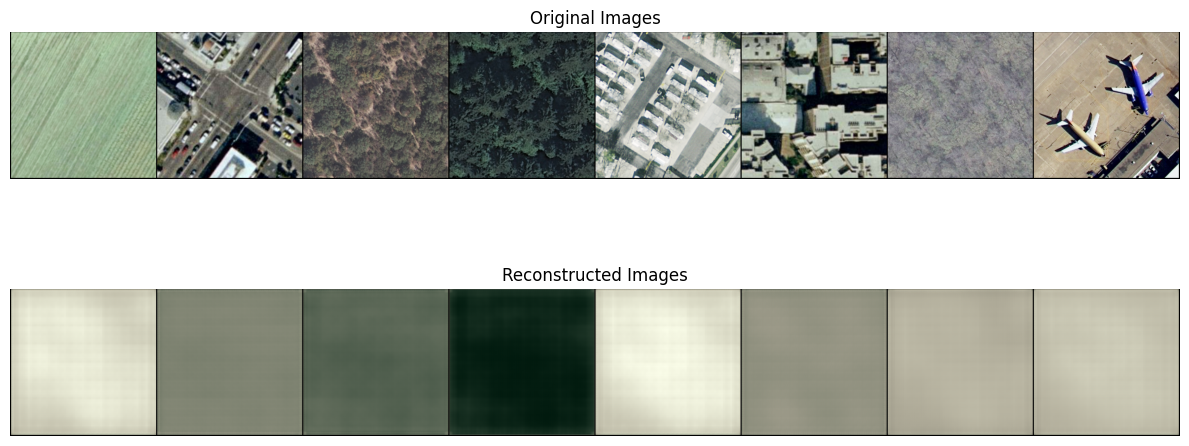


Epoch 31/1000
Current beta values: beta1=0.0620, beta2=0.0620


Validation: 100%|██████████| 7/7 [00:00<00:00, 17.52it/s]


Train Loss: 6284.940572, Val Loss: 6694.564137
Train Recon: 6246.137851, KL1: 312.925170, KL2: 312.925170
Val Recon: 6653.230804, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 32/1000
Current beta values: beta1=0.0640, beta2=0.0640


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.12it/s]


Train Loss: 6323.788946, Val Loss: 6713.336942
Train Recon: 6283.734524, KL1: 312.925170, KL2: 312.925170
Val Recon: 6670.670275, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 33/1000
Current beta values: beta1=0.0660, beta2=0.0660


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.73it/s]


Train Loss: 6302.785523, Val Loss: 6718.275149
Train Recon: 6261.479401, KL1: 312.925170, KL2: 312.925170
Val Recon: 6674.275149, KL1: 333.333333, KL2: 333.333333
No improvement for 3 epochs

Epoch 34/1000
Current beta values: beta1=0.0680, beta2=0.0680


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.54it/s]


Train Loss: 6297.891263, Val Loss: 6714.698661
Train Recon: 6255.333440, KL1: 312.925170, KL2: 312.925170
Val Recon: 6669.365327, KL1: 333.333333, KL2: 333.333333
No improvement for 4 epochs

Epoch 35/1000
Current beta values: beta1=0.0700, beta2=0.0700


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.53it/s]


Train Loss: 6315.414286, Val Loss: 6761.339732
Train Recon: 6271.604762, KL1: 312.925170, KL2: 312.925170
Val Recon: 6714.673065, KL1: 333.333333, KL2: 333.333333
No improvement for 5 epochs

Epoch 36/1000
Current beta values: beta1=0.0720, beta2=0.0720


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.97it/s]


Train Loss: 6345.644462, Val Loss: 6720.514174
Train Recon: 6300.583238, KL1: 312.925170, KL2: 312.925170
Val Recon: 6672.514174, KL1: 333.333333, KL2: 333.333333
No improvement for 6 epochs

Epoch 37/1000
Current beta values: beta1=0.0740, beta2=0.0740


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.22it/s]


Train Loss: 6337.593984, Val Loss: 6710.584338
Train Recon: 6291.281059, KL1: 312.925170, KL2: 312.925170
Val Recon: 6661.251004, KL1: 333.333333, KL2: 333.333333
No improvement for 7 epochs

Epoch 38/1000
Current beta values: beta1=0.0760, beta2=0.0760


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.96it/s]


Train Loss: 6576.075765, Val Loss: 6910.598958
Train Recon: 6528.511139, KL1: 312.925170, KL2: 312.925170
Val Recon: 6859.932292, KL1: 333.333333, KL2: 333.333333
No improvement for 8 epochs

Epoch 39/1000
Current beta values: beta1=0.0780, beta2=0.0780


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.58it/s]


Train Loss: 6384.348576, Val Loss: 6739.168973
Train Recon: 6335.532249, KL1: 312.925170, KL2: 312.925170
Val Recon: 6687.168973, KL1: 333.333333, KL2: 333.333333
No improvement for 9 epochs

Epoch 40/1000
Current beta values: beta1=0.0800, beta2=0.0800


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.11it/s]


Train Loss: 6318.206771, Val Loss: 6768.993899
Train Recon: 6268.138744, KL1: 312.925170, KL2: 312.925170
Val Recon: 6715.660565, KL1: 333.333333, KL2: 333.333333
No improvement for 10 epochs

Epoch 41/1000
Current beta values: beta1=0.0820, beta2=0.0820


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


Train Loss: 6295.489349, Val Loss: 6710.159747
Train Recon: 6244.169622, KL1: 312.925170, KL2: 312.925170
Val Recon: 6655.493080, KL1: 333.333333, KL2: 333.333333
No improvement for 11 epochs

Epoch 42/1000
Current beta values: beta1=0.0840, beta2=0.0840


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.43it/s]


Train Loss: 6335.150595, Val Loss: 6728.702827
Train Recon: 6282.579167, KL1: 312.925170, KL2: 312.925170
Val Recon: 6672.702827, KL1: 333.333333, KL2: 333.333333
No improvement for 12 epochs

Epoch 43/1000
Current beta values: beta1=0.0860, beta2=0.0860


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.41it/s]


Train Loss: 6307.062851, Val Loss: 6719.500298
Train Recon: 6253.239722, KL1: 312.925170, KL2: 312.925170
Val Recon: 6662.166964, KL1: 333.333333, KL2: 333.333333
No improvement for 13 epochs

Epoch 44/1000
Current beta values: beta1=0.0880, beta2=0.0880


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.36it/s]


Train Loss: 6325.001616, Val Loss: 6778.638281
Train Recon: 6269.926786, KL1: 312.925170, KL2: 312.925170
Val Recon: 6719.971615, KL1: 333.333333, KL2: 333.333333
No improvement for 14 epochs

Epoch 45/1000
Current beta values: beta1=0.0900, beta2=0.0900


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.92it/s]


Train Loss: 6331.978348, Val Loss: 6685.019196
Train Recon: 6275.651818, KL1: 312.925170, KL2: 312.925170
Val Recon: 6625.019196, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6685.019196

Epoch 46/1000
Current beta values: beta1=0.0920, beta2=0.0920


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.19it/s]


Train Loss: 6314.184651, Val Loss: 6739.224256
Train Recon: 6256.606420, KL1: 312.925170, KL2: 312.925170
Val Recon: 6677.890923, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 47/1000
Current beta values: beta1=0.0940, beta2=0.0940


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.76it/s]


Train Loss: 6327.813212, Val Loss: 6756.711682
Train Recon: 6268.983280, KL1: 312.925170, KL2: 312.925170
Val Recon: 6694.045015, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 48/1000
Current beta values: beta1=0.0960, beta2=0.0960


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


Train Loss: 6347.617538, Val Loss: 6721.180283
Train Recon: 6287.535906, KL1: 312.925170, KL2: 312.925170
Val Recon: 6657.180283, KL1: 333.333333, KL2: 333.333333
No improvement for 3 epochs

Epoch 49/1000
Current beta values: beta1=0.0980, beta2=0.0980


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.60it/s]


Train Loss: 6314.666018, Val Loss: 6662.213356
Train Recon: 6253.332685, KL1: 312.925170, KL2: 312.925170
Val Recon: 6596.880022, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6662.213356

Epoch 50/1000
Current beta values: beta1=0.1000, beta2=0.1000


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.39it/s]


Train Loss: 6253.735682, Val Loss: 6669.473884
Train Recon: 6191.150648, KL1: 312.925170, KL2: 312.925170
Val Recon: 6602.807217, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 51/1000
Current beta values: beta1=0.1020, beta2=0.1020


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.75it/s]


Train Loss: 6259.861820, Val Loss: 6641.508036
Train Recon: 6196.025085, KL1: 312.925170, KL2: 312.925170
Val Recon: 6573.508036, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6641.508036

Epoch 52/1000
Current beta values: beta1=0.1040, beta2=0.1040


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.76it/s]


Train Loss: 6211.112319, Val Loss: 6615.438430
Train Recon: 6146.023884, KL1: 312.925170, KL2: 312.925170
Val Recon: 6546.105097, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6615.438430

Epoch 53/1000
Current beta values: beta1=0.1060, beta2=0.1060


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


Train Loss: 6162.248182, Val Loss: 6584.413393
Train Recon: 6095.908046, KL1: 312.925170, KL2: 312.925170
Val Recon: 6513.746726, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6584.413393

Epoch 54/1000
Current beta values: beta1=0.1080, beta2=0.1080


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


Train Loss: 6130.905889, Val Loss: 6541.664955
Train Recon: 6063.314052, KL1: 312.925170, KL2: 312.925170
Val Recon: 6469.664955, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6541.664955

Epoch 55/1000
Current beta values: beta1=0.1100, beta2=0.1100


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


Train Loss: 6121.104751, Val Loss: 6701.401042
Train Recon: 6052.261214, KL1: 312.925170, KL2: 312.925170
Val Recon: 6628.067708, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 56/1000
Current beta values: beta1=0.1120, beta2=0.1120


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.66it/s]


Train Loss: 6113.276722, Val Loss: 6548.449033
Train Recon: 6043.181484, KL1: 312.925170, KL2: 312.925170
Val Recon: 6473.782366, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 57/1000
Current beta values: beta1=0.1140, beta2=0.1140


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


Train Loss: 6137.771567, Val Loss: 6666.276600
Train Recon: 6066.424628, KL1: 312.925170, KL2: 312.925170
Val Recon: 6590.276600, KL1: 333.333333, KL2: 333.333333
No improvement for 3 epochs

Epoch 58/1000
Current beta values: beta1=0.1160, beta2=0.1160


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.73it/s]


Train Loss: 6119.979709, Val Loss: 6553.780878
Train Recon: 6047.381069, KL1: 312.925170, KL2: 312.925170
Val Recon: 6476.447545, KL1: 333.333333, KL2: 333.333333
No improvement for 4 epochs

Epoch 59/1000
Current beta values: beta1=0.1180, beta2=0.1180


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.70it/s]


Train Loss: 6108.083099, Val Loss: 6529.970387
Train Recon: 6034.232759, KL1: 312.925170, KL2: 312.925170
Val Recon: 6451.303720, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6529.970387

Epoch 60/1000
Current beta values: beta1=0.1200, beta2=0.1200


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.61it/s]


Train Loss: 6110.267134, Val Loss: 6500.522582
Train Recon: 6035.165094, KL1: 312.925170, KL2: 312.925170
Val Recon: 6420.522582, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6500.522582


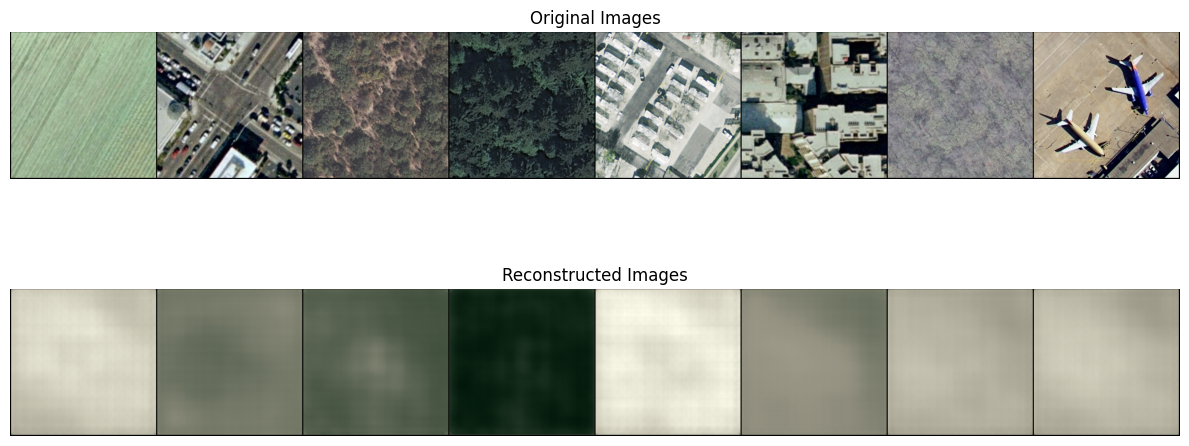


Epoch 61/1000
Current beta values: beta1=0.1220, beta2=0.1220


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.49it/s]


Train Loss: 6047.920642, Val Loss: 6457.165179
Train Recon: 5971.566901, KL1: 312.925170, KL2: 312.925170
Val Recon: 6375.831845, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6457.165179

Epoch 62/1000
Current beta values: beta1=0.1240, beta2=0.1240


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.24it/s]


Train Loss: 5953.358652, Val Loss: 6437.338690
Train Recon: 5875.753210, KL1: 312.925170, KL2: 312.925170
Val Recon: 6354.672024, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6437.338690

Epoch 63/1000
Current beta values: beta1=0.1260, beta2=0.1260


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.30it/s]


Train Loss: 5923.930931, Val Loss: 6399.961384
Train Recon: 5845.073788, KL1: 312.925170, KL2: 312.925170
Val Recon: 6315.961384, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6399.961384

Epoch 64/1000
Current beta values: beta1=0.1280, beta2=0.1280


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


Train Loss: 5936.611373, Val Loss: 6394.538765
Train Recon: 5856.502530, KL1: 312.925170, KL2: 312.925170
Val Recon: 6309.205432, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6394.538765

Epoch 65/1000
Current beta values: beta1=0.1300, beta2=0.1300


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.05it/s]


Train Loss: 5981.371747, Val Loss: 6549.422805
Train Recon: 5900.011203, KL1: 312.925170, KL2: 312.925170
Val Recon: 6462.756138, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 66/1000
Current beta values: beta1=0.1320, beta2=0.1320


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.94it/s]


Train Loss: 5982.624957, Val Loss: 6398.608854
Train Recon: 5900.012713, KL1: 312.925170, KL2: 312.925170
Val Recon: 6310.608854, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 67/1000
Current beta values: beta1=0.1340, beta2=0.1340


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.63it/s]


Train Loss: 5877.406526, Val Loss: 6330.796615
Train Recon: 5793.542581, KL1: 312.925170, KL2: 312.925170
Val Recon: 6241.463281, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6330.796615

Epoch 68/1000
Current beta values: beta1=0.1360, beta2=0.1360


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.46it/s]


Train Loss: 5848.956409, Val Loss: 6318.903125
Train Recon: 5763.840763, KL1: 312.925170, KL2: 312.925170
Val Recon: 6228.236458, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6318.903125

Epoch 69/1000
Current beta values: beta1=0.1380, beta2=0.1380


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.36it/s]


Train Loss: 5829.934933, Val Loss: 6395.413021
Train Recon: 5743.567586, KL1: 312.925170, KL2: 312.925170
Val Recon: 6303.413021, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 70/1000
Current beta values: beta1=0.1400, beta2=0.1400


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s]


Train Loss: 5814.946981, Val Loss: 6304.133296
Train Recon: 5727.327934, KL1: 312.925170, KL2: 312.925170
Val Recon: 6210.799963, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6304.133296

Epoch 71/1000
Current beta values: beta1=0.1420, beta2=0.1420


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.06it/s]


Train Loss: 5791.731239, Val Loss: 6290.626488
Train Recon: 5702.860491, KL1: 312.925170, KL2: 312.925170
Val Recon: 6195.959821, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6290.626488

Epoch 72/1000
Current beta values: beta1=0.1440, beta2=0.1440


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.32it/s]


Train Loss: 5760.177349, Val Loss: 6228.955208
Train Recon: 5670.054900, KL1: 312.925170, KL2: 312.925170
Val Recon: 6132.955208, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6228.955208

Epoch 73/1000
Current beta values: beta1=0.1460, beta2=0.1460


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.35it/s]


Train Loss: 5746.093442, Val Loss: 6306.127530
Train Recon: 5654.719292, KL1: 312.925170, KL2: 312.925170
Val Recon: 6208.794196, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 74/1000
Current beta values: beta1=0.1480, beta2=0.1480


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.03it/s]


Train Loss: 5782.515965, Val Loss: 6281.976042
Train Recon: 5689.890115, KL1: 312.925170, KL2: 312.925170
Val Recon: 6183.309375, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 75/1000
Current beta values: beta1=0.1500, beta2=0.1500


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.42it/s]


Train Loss: 5771.149745, Val Loss: 6258.501265
Train Recon: 5677.272194, KL1: 312.925170, KL2: 312.925170
Val Recon: 6158.501265, KL1: 333.333333, KL2: 333.333333
No improvement for 3 epochs

Epoch 76/1000
Current beta values: beta1=0.1520, beta2=0.1520


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.87it/s]


Train Loss: 5727.185087, Val Loss: 6284.692708
Train Recon: 5632.055835, KL1: 312.925170, KL2: 312.925170
Val Recon: 6183.359375, KL1: 333.333333, KL2: 333.333333
No improvement for 4 epochs

Epoch 77/1000
Current beta values: beta1=0.1540, beta2=0.1540


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.36it/s]


Train Loss: 5756.366263, Val Loss: 6237.293973
Train Recon: 5659.985310, KL1: 312.925170, KL2: 312.925170
Val Recon: 6134.627307, KL1: 333.333333, KL2: 333.333333
No improvement for 5 epochs

Epoch 78/1000
Current beta values: beta1=0.1560, beta2=0.1560


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.89it/s]


Train Loss: 5753.076350, Val Loss: 6258.329911
Train Recon: 5655.443697, KL1: 312.925170, KL2: 312.925170
Val Recon: 6154.329911, KL1: 333.333333, KL2: 333.333333
No improvement for 6 epochs

Epoch 79/1000
Current beta values: beta1=0.1580, beta2=0.1580


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.74it/s]


Train Loss: 5726.918304, Val Loss: 6261.477307
Train Recon: 5628.033950, KL1: 312.925170, KL2: 312.925170
Val Recon: 6156.143973, KL1: 333.333333, KL2: 333.333333
No improvement for 7 epochs

Epoch 80/1000
Current beta values: beta1=0.1600, beta2=0.1600


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.14it/s]


Train Loss: 5776.614403, Val Loss: 6258.772396
Train Recon: 5676.478348, KL1: 312.925170, KL2: 312.925170
Val Recon: 6152.105729, KL1: 333.333333, KL2: 333.333333
No improvement for 8 epochs

Epoch 81/1000
Current beta values: beta1=0.1620, beta2=0.1620


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.82it/s]


Train Loss: 5762.334800, Val Loss: 6270.211533
Train Recon: 5660.947045, KL1: 312.925170, KL2: 312.925170
Val Recon: 6162.211533, KL1: 333.333333, KL2: 333.333333
No improvement for 9 epochs

Epoch 82/1000
Current beta values: beta1=0.1640, beta2=0.1640


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.61it/s]


Train Loss: 5744.141061, Val Loss: 6261.585417
Train Recon: 5641.501605, KL1: 312.925170, KL2: 312.925170
Val Recon: 6152.252083, KL1: 333.333333, KL2: 333.333333
No improvement for 10 epochs

Epoch 83/1000
Current beta values: beta1=0.1660, beta2=0.1660


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


Train Loss: 5731.442804, Val Loss: 6382.249330
Train Recon: 5627.551648, KL1: 312.925170, KL2: 312.925170
Val Recon: 6271.582664, KL1: 333.333333, KL2: 333.333333
No improvement for 11 epochs

Epoch 84/1000
Current beta values: beta1=0.1680, beta2=0.1680


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.82it/s]


Train Loss: 5746.642113, Val Loss: 6280.508482
Train Recon: 5641.499256, KL1: 312.925170, KL2: 312.925170
Val Recon: 6168.508482, KL1: 333.333333, KL2: 333.333333
No improvement for 12 epochs

Epoch 85/1000
Current beta values: beta1=0.1700, beta2=0.1700


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.64it/s]


Train Loss: 5737.672502, Val Loss: 6411.007366
Train Recon: 5631.277944, KL1: 312.925170, KL2: 312.925170
Val Recon: 6297.674033, KL1: 333.333333, KL2: 333.333333
No improvement for 13 epochs

Epoch 86/1000
Current beta values: beta1=0.1720, beta2=0.1720


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.55it/s]


Train Loss: 5730.365955, Val Loss: 7180.785863
Train Recon: 5622.719696, KL1: 312.925170, KL2: 312.925170
Val Recon: 7066.119196, KL1: 333.333333, KL2: 333.333333
No improvement for 14 epochs

Epoch 87/1000
Current beta values: beta1=0.1740, beta2=0.1740


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.94it/s]


Train Loss: 5739.859821, Val Loss: 6333.597693
Train Recon: 5630.961862, KL1: 312.925170, KL2: 312.925170
Val Recon: 6217.597693, KL1: 333.333333, KL2: 333.333333
No improvement for 15 epochs

Epoch 88/1000
Current beta values: beta1=0.1760, beta2=0.1760


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.37it/s]


Train Loss: 5696.330368, Val Loss: 6280.952232
Train Recon: 5586.180708, KL1: 312.925170, KL2: 312.925170
Val Recon: 6163.618899, KL1: 333.333333, KL2: 333.333333
No improvement for 16 epochs

Epoch 89/1000
Current beta values: beta1=0.1780, beta2=0.1780


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.73it/s]


Train Loss: 5749.884481, Val Loss: 6258.342001
Train Recon: 5638.483121, KL1: 312.925170, KL2: 312.925170
Val Recon: 6139.675335, KL1: 333.333333, KL2: 333.333333
No improvement for 17 epochs

Epoch 90/1000
Current beta values: beta1=0.1800, beta2=0.1800


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.06it/s]

Train Loss: 5751.646907, Val Loss: 6639.491741
Train Recon: 5638.993846, KL1: 312.925170, KL2: 312.925170
Val Recon: 6519.491741, KL1: 333.333333, KL2: 333.333333
No improvement for 18 epochs


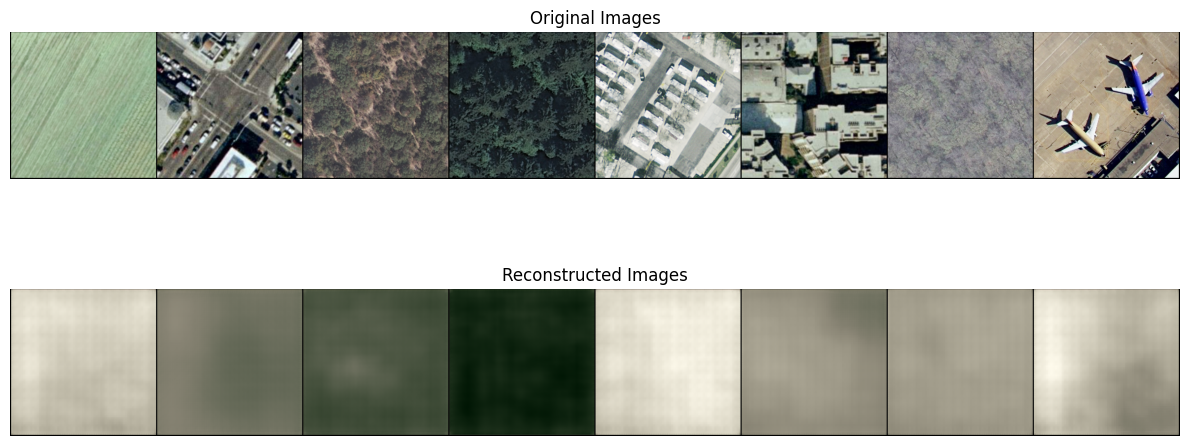


Epoch 91/1000
Current beta values: beta1=0.1820, beta2=0.1820


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.40it/s]


Train Loss: 5728.175266, Val Loss: 6302.465997
Train Recon: 5614.270504, KL1: 312.925170, KL2: 312.925170
Val Recon: 6181.132664, KL1: 333.333333, KL2: 333.333333
No improvement for 19 epochs

Epoch 92/1000
Current beta values: beta1=0.1840, beta2=0.1840


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.03it/s]


Train Loss: 5727.850829, Val Loss: 6164.283185
Train Recon: 5612.694366, KL1: 312.925170, KL2: 312.925170
Val Recon: 6041.616518, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6164.283185

Epoch 93/1000
Current beta values: beta1=0.1860, beta2=0.1860


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.09it/s]


Train Loss: 5666.553465, Val Loss: 6119.877716
Train Recon: 5550.145302, KL1: 312.925170, KL2: 312.925170
Val Recon: 5995.877716, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6119.877716

Epoch 94/1000
Current beta values: beta1=0.1880, beta2=0.1880


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.54it/s]


Train Loss: 5637.517304, Val Loss: 6133.602381
Train Recon: 5519.857440, KL1: 312.925170, KL2: 312.925170
Val Recon: 6008.269048, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 95/1000
Current beta values: beta1=0.1900, beta2=0.1900


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.71it/s]


Train Loss: 5602.412128, Val Loss: 6108.743192
Train Recon: 5483.500563, KL1: 312.925170, KL2: 312.925170
Val Recon: 5982.076525, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6108.743192

Epoch 96/1000
Current beta values: beta1=0.1920, beta2=0.1920


Validation: 100%|██████████| 7/7 [00:00<00:00, 17.82it/s]


Train Loss: 5616.682738, Val Loss: 6201.545685
Train Recon: 5496.519473, KL1: 312.925170, KL2: 312.925170
Val Recon: 6073.545685, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 97/1000
Current beta values: beta1=0.1940, beta2=0.1940


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


Train Loss: 5640.873969, Val Loss: 6130.066220
Train Recon: 5519.459003, KL1: 312.925170, KL2: 312.925170
Val Recon: 6000.732887, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 98/1000
Current beta values: beta1=0.1960, beta2=0.1960


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.20it/s]


Train Loss: 5616.879443, Val Loss: 6095.531436
Train Recon: 5494.212776, KL1: 312.925170, KL2: 312.925170
Val Recon: 5964.864769, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6095.531436

Epoch 99/1000
Current beta values: beta1=0.1980, beta2=0.1980


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.26it/s]


Train Loss: 5592.241805, Val Loss: 6105.548549
Train Recon: 5468.323443, KL1: 312.925170, KL2: 312.925170
Val Recon: 5973.548549, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 100/1000
Current beta values: beta1=0.2000, beta2=0.2000


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.53it/s]


Train Loss: 5595.456463, Val Loss: 6091.786533
Train Recon: 5470.286395, KL1: 312.925170, KL2: 312.925170
Val Recon: 5958.453199, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6091.786533

Epoch 101/1000
Current beta values: beta1=0.2020, beta2=0.2020


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.60it/s]


Train Loss: 5566.291853, Val Loss: 6091.883185
Train Recon: 5439.870084, KL1: 312.925170, KL2: 312.925170
Val Recon: 5957.216518, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 102/1000
Current beta values: beta1=0.2040, beta2=0.2040


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.76it/s]


Train Loss: 5580.610108, Val Loss: 6089.474702
Train Recon: 5452.936639, KL1: 312.925170, KL2: 312.925170
Val Recon: 5953.474702, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6089.474702

Epoch 103/1000
Current beta values: beta1=0.2060, beta2=0.2060


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.22it/s]


Train Loss: 5586.464945, Val Loss: 6115.578311
Train Recon: 5457.539775, KL1: 312.925170, KL2: 312.925170
Val Recon: 5978.244978, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 104/1000
Current beta values: beta1=0.2080, beta2=0.2080


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.71it/s]


Train Loss: 5598.177859, Val Loss: 6101.743080
Train Recon: 5468.000989, KL1: 312.925170, KL2: 312.925170
Val Recon: 5963.076414, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 105/1000
Current beta values: beta1=0.2100, beta2=0.2100


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.57it/s]


Train Loss: 5595.968612, Val Loss: 6085.970238
Train Recon: 5464.540040, KL1: 312.925170, KL2: 312.925170
Val Recon: 5945.970238, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6085.970238

Epoch 106/1000
Current beta values: beta1=0.2120, beta2=0.2120


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


Train Loss: 5603.614955, Val Loss: 6151.286756
Train Recon: 5470.934683, KL1: 312.925170, KL2: 312.925170
Val Recon: 6009.953423, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 107/1000
Current beta values: beta1=0.2140, beta2=0.2140


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.97it/s]


Train Loss: 5566.434162, Val Loss: 6084.469494
Train Recon: 5432.502190, KL1: 312.925170, KL2: 312.925170
Val Recon: 5941.802827, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6084.469494

Epoch 108/1000
Current beta values: beta1=0.2160, beta2=0.2160


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.97it/s]


Train Loss: 5537.471200, Val Loss: 6085.037351
Train Recon: 5402.287527, KL1: 312.925170, KL2: 312.925170
Val Recon: 5941.037351, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 109/1000
Current beta values: beta1=0.2180, beta2=0.2180


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.98it/s]


Train Loss: 5561.353757, Val Loss: 6030.615923
Train Recon: 5424.918383, KL1: 312.925170, KL2: 312.925170
Val Recon: 5885.282589, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6030.615923

Epoch 110/1000
Current beta values: beta1=0.2200, beta2=0.2200


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.95it/s]


Train Loss: 5523.408429, Val Loss: 6013.497768
Train Recon: 5385.721354, KL1: 312.925170, KL2: 312.925170
Val Recon: 5866.831101, KL1: 333.333333, KL2: 333.333333
New best validation loss: 6013.497768

Epoch 111/1000
Current beta values: beta1=0.2220, beta2=0.2220


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.65it/s]


Train Loss: 5526.760119, Val Loss: 6014.035714
Train Recon: 5387.821344, KL1: 312.925170, KL2: 312.925170
Val Recon: 5866.035714, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 112/1000
Current beta values: beta1=0.2240, beta2=0.2240


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


Train Loss: 5483.971593, Val Loss: 5998.059412
Train Recon: 5343.781117, KL1: 312.925170, KL2: 312.925170
Val Recon: 5848.726079, KL1: 333.333333, KL2: 333.333333
New best validation loss: 5998.059412

Epoch 113/1000
Current beta values: beta1=0.2260, beta2=0.2260


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


Train Loss: 5505.080240, Val Loss: 6047.960640
Train Recon: 5363.638069, KL1: 312.925170, KL2: 312.925170
Val Recon: 5897.293973, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 114/1000
Current beta values: beta1=0.2280, beta2=0.2280


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.62it/s]


Train Loss: 5473.853104, Val Loss: 6010.968229
Train Recon: 5331.159226, KL1: 312.925170, KL2: 312.925170
Val Recon: 5858.968229, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 115/1000
Current beta values: beta1=0.2300, beta2=0.2300


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.13it/s]


Train Loss: 5518.526323, Val Loss: 6019.926711
Train Recon: 5374.580745, KL1: 312.925170, KL2: 312.925170
Val Recon: 5866.593378, KL1: 333.333333, KL2: 333.333333
No improvement for 3 epochs

Epoch 116/1000
Current beta values: beta1=0.2320, beta2=0.2320


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


Train Loss: 5439.686926, Val Loss: 6026.727381
Train Recon: 5294.489647, KL1: 312.925170, KL2: 312.925170
Val Recon: 5872.060714, KL1: 333.333333, KL2: 333.333333
No improvement for 4 epochs

Epoch 117/1000
Current beta values: beta1=0.2340, beta2=0.2340


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.19it/s]


Train Loss: 5437.713605, Val Loss: 6015.954315
Train Recon: 5291.264626, KL1: 312.925170, KL2: 312.925170
Val Recon: 5859.954315, KL1: 333.333333, KL2: 333.333333
No improvement for 5 epochs

Epoch 118/1000
Current beta values: beta1=0.2360, beta2=0.2360


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


Train Loss: 5437.594834, Val Loss: 6016.956845
Train Recon: 5289.894154, KL1: 312.925170, KL2: 312.925170
Val Recon: 5859.623512, KL1: 333.333333, KL2: 333.333333
No improvement for 6 epochs

Epoch 119/1000
Current beta values: beta1=0.2380, beta2=0.2380


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.06it/s]


Train Loss: 5472.900489, Val Loss: 6119.366443
Train Recon: 5323.948108, KL1: 312.925170, KL2: 312.925170
Val Recon: 5960.699777, KL1: 333.333333, KL2: 333.333333
No improvement for 7 epochs

Epoch 120/1000
Current beta values: beta1=0.2400, beta2=0.2400


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.59it/s]

Train Loss: 5531.967283, Val Loss: 7855.715699
Train Recon: 5381.763202, KL1: 312.925170, KL2: 312.925170
Val Recon: 7695.715699, KL1: 333.333333, KL2: 333.333333
No improvement for 8 epochs


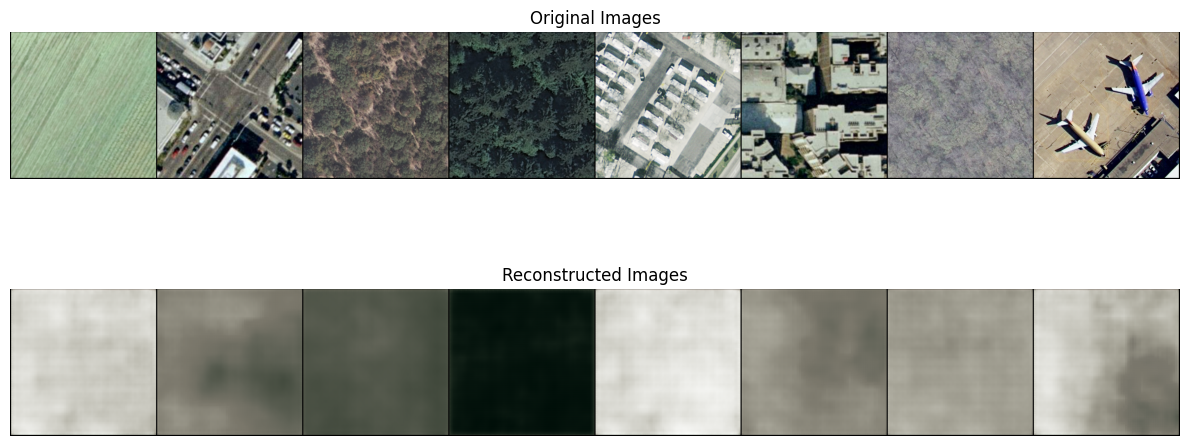


Epoch 121/1000
Current beta values: beta1=0.2420, beta2=0.2420


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.75it/s]


Train Loss: 5532.861108, Val Loss: 6304.068080
Train Recon: 5381.405325, KL1: 312.925170, KL2: 312.925170
Val Recon: 6142.734747, KL1: 333.333333, KL2: 333.333333
No improvement for 9 epochs

Epoch 122/1000
Current beta values: beta1=0.2440, beta2=0.2440


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.09it/s]


Train Loss: 5514.679454, Val Loss: 6092.816369
Train Recon: 5361.971971, KL1: 312.925170, KL2: 312.925170
Val Recon: 5930.149702, KL1: 333.333333, KL2: 333.333333
No improvement for 10 epochs

Epoch 123/1000
Current beta values: beta1=0.2460, beta2=0.2460


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.94it/s]


Train Loss: 5434.780942, Val Loss: 6059.425930
Train Recon: 5280.821758, KL1: 312.925170, KL2: 312.925170
Val Recon: 5895.425930, KL1: 333.333333, KL2: 333.333333
No improvement for 11 epochs

Epoch 124/1000
Current beta values: beta1=0.2480, beta2=0.2480


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.52it/s]


Train Loss: 5427.814913, Val Loss: 6032.717188
Train Recon: 5272.604028, KL1: 312.925170, KL2: 312.925170
Val Recon: 5867.383854, KL1: 333.333333, KL2: 333.333333
No improvement for 12 epochs

Epoch 125/1000
Current beta values: beta1=0.2500, beta2=0.2500


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.45it/s]


Train Loss: 5431.389716, Val Loss: 6200.153348
Train Recon: 5274.927131, KL1: 312.925170, KL2: 312.925170
Val Recon: 6033.486682, KL1: 333.333333, KL2: 333.333333
No improvement for 13 epochs

Epoch 126/1000
Current beta values: beta1=0.2520, beta2=0.2520


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.69it/s]


Train Loss: 5386.776302, Val Loss: 6026.692857
Train Recon: 5229.062016, KL1: 312.925170, KL2: 312.925170
Val Recon: 5858.692857, KL1: 333.333333, KL2: 333.333333
No improvement for 14 epochs

Epoch 127/1000
Current beta values: beta1=0.2540, beta2=0.2540


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.13it/s]


Train Loss: 5433.245307, Val Loss: 6009.719829
Train Recon: 5274.279321, KL1: 312.925170, KL2: 312.925170
Val Recon: 5840.386496, KL1: 333.333333, KL2: 333.333333
No improvement for 15 epochs

Epoch 128/1000
Current beta values: beta1=0.2560, beta2=0.2560


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.35it/s]


Train Loss: 5418.951254, Val Loss: 6000.147396
Train Recon: 5258.733567, KL1: 312.925170, KL2: 312.925170
Val Recon: 5829.480729, KL1: 333.333333, KL2: 333.333333
No improvement for 16 epochs

Epoch 129/1000
Current beta values: beta1=0.2580, beta2=0.2580


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.10it/s]


Train Loss: 5382.150175, Val Loss: 5986.926935
Train Recon: 5220.680788, KL1: 312.925170, KL2: 312.925170
Val Recon: 5814.926935, KL1: 333.333333, KL2: 333.333333
New best validation loss: 5986.926935

Epoch 130/1000
Current beta values: beta1=0.2600, beta2=0.2600


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.19it/s]


Train Loss: 5340.915009, Val Loss: 6004.502009
Train Recon: 5178.193915, KL1: 312.925170, KL2: 312.925170
Val Recon: 5831.168676, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 131/1000
Current beta values: beta1=0.2620, beta2=0.2620


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.33it/s]


Train Loss: 5380.781766, Val Loss: 5970.857515
Train Recon: 5216.808976, KL1: 312.925170, KL2: 312.925170
Val Recon: 5796.190848, KL1: 333.333333, KL2: 333.333333
New best validation loss: 5970.857515

Epoch 132/1000
Current beta values: beta1=0.2640, beta2=0.2640


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.88it/s]


Train Loss: 5322.824702, Val Loss: 6027.144643
Train Recon: 5157.600213, KL1: 312.925170, KL2: 312.925170
Val Recon: 5851.144643, KL1: 333.333333, KL2: 333.333333
No improvement for 1 epochs

Epoch 133/1000
Current beta values: beta1=0.2660, beta2=0.2660


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.34it/s]


Train Loss: 5336.373523, Val Loss: 5978.336644
Train Recon: 5169.897332, KL1: 312.925170, KL2: 312.925170
Val Recon: 5801.003311, KL1: 333.333333, KL2: 333.333333
No improvement for 2 epochs

Epoch 134/1000
Current beta values: beta1=0.2680, beta2=0.2680


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.02it/s]


Train Loss: 5306.873299, Val Loss: 6029.621057
Train Recon: 5139.145408, KL1: 312.925170, KL2: 312.925170
Val Recon: 5850.954390, KL1: 333.333333, KL2: 333.333333
No improvement for 3 epochs

Epoch 135/1000
Current beta values: beta1=0.2700, beta2=0.2700


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.88it/s]


Train Loss: 5343.592963, Val Loss: 6018.777902
Train Recon: 5174.613372, KL1: 312.925170, KL2: 312.925170
Val Recon: 5838.777902, KL1: 333.333333, KL2: 333.333333
No improvement for 4 epochs

Epoch 136/1000
Current beta values: beta1=0.2720, beta2=0.2720


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.66it/s]


Train Loss: 5333.638754, Val Loss: 6000.580729
Train Recon: 5163.407456, KL1: 312.925170, KL2: 312.925170
Val Recon: 5819.247396, KL1: 333.333333, KL2: 333.333333
No improvement for 5 epochs

Epoch 137/1000
Current beta values: beta1=0.2740, beta2=0.2740


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.31it/s]


Train Loss: 5314.873034, Val Loss: 5979.894234
Train Recon: 5143.390040, KL1: 312.925170, KL2: 312.925170
Val Recon: 5797.227567, KL1: 333.333333, KL2: 333.333333
No improvement for 6 epochs

Epoch 138/1000
Current beta values: beta1=0.2760, beta2=0.2760


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.90it/s]


Train Loss: 5262.489371, Val Loss: 5979.069568
Train Recon: 5089.754672, KL1: 312.925170, KL2: 312.925170
Val Recon: 5795.069568, KL1: 333.333333, KL2: 333.333333
No improvement for 7 epochs

Epoch 139/1000
Current beta values: beta1=0.2780, beta2=0.2780


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.53it/s]


Train Loss: 5287.718516, Val Loss: 6069.375707
Train Recon: 5113.732116, KL1: 312.925170, KL2: 312.925170
Val Recon: 5884.042374, KL1: 333.333333, KL2: 333.333333
No improvement for 8 epochs

Epoch 140/1000
Current beta values: beta1=0.2800, beta2=0.2800


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.10it/s]


Train Loss: 5281.843601, Val Loss: 6046.222619
Train Recon: 5106.605501, KL1: 312.925170, KL2: 312.925170
Val Recon: 5859.555952, KL1: 333.333333, KL2: 333.333333
No improvement for 9 epochs

Epoch 141/1000
Current beta values: beta1=0.2820, beta2=0.2820


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.93it/s]


Train Loss: 5278.552896, Val Loss: 6105.427195
Train Recon: 5102.063101, KL1: 312.925170, KL2: 312.925170
Val Recon: 5917.427195, KL1: 333.333333, KL2: 333.333333
No improvement for 10 epochs

Epoch 142/1000
Current beta values: beta1=0.2840, beta2=0.2840


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.22it/s]


Train Loss: 5246.648246, Val Loss: 5982.833110
Train Recon: 5068.906750, KL1: 312.925170, KL2: 312.925170
Val Recon: 5793.499777, KL1: 333.333333, KL2: 333.333333
No improvement for 11 epochs

Epoch 143/1000
Current beta values: beta1=0.2860, beta2=0.2860


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.97it/s]


Train Loss: 5251.435603, Val Loss: 6124.094494
Train Recon: 5072.442405, KL1: 312.925170, KL2: 312.925170
Val Recon: 5933.427827, KL1: 333.333333, KL2: 333.333333
No improvement for 12 epochs

Epoch 144/1000
Current beta values: beta1=0.2880, beta2=0.2880


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.90it/s]


Train Loss: 5255.539881, Val Loss: 5992.452083
Train Recon: 5075.294983, KL1: 312.925170, KL2: 312.925170
Val Recon: 5800.452083, KL1: 333.333333, KL2: 333.333333
No improvement for 13 epochs

Epoch 145/1000
Current beta values: beta1=0.2900, beta2=0.2900


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.48it/s]


Train Loss: 5274.318080, Val Loss: 6002.137202
Train Recon: 5092.821476, KL1: 312.925170, KL2: 312.925170
Val Recon: 5808.803869, KL1: 333.333333, KL2: 333.333333
No improvement for 14 epochs

Epoch 146/1000
Current beta values: beta1=0.2920, beta2=0.2920


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.75it/s]


Train Loss: 5241.313526, Val Loss: 6014.739472
Train Recon: 5058.565232, KL1: 312.925170, KL2: 312.925170
Val Recon: 5820.072805, KL1: 333.333333, KL2: 333.333333
No improvement for 15 epochs

Epoch 147/1000
Current beta values: beta1=0.2940, beta2=0.2940


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.64it/s]


Train Loss: 5189.764711, Val Loss: 6056.205878
Train Recon: 5005.764706, KL1: 312.925170, KL2: 312.925170
Val Recon: 5860.205878, KL1: 333.333333, KL2: 333.333333
No improvement for 16 epochs

Epoch 148/1000
Current beta values: beta1=0.2960, beta2=0.2960


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.26it/s]


Train Loss: 5241.573682, Val Loss: 6057.945573
Train Recon: 5056.321987, KL1: 312.925170, KL2: 312.925170
Val Recon: 5860.612240, KL1: 333.333333, KL2: 333.333333
No improvement for 17 epochs

Epoch 149/1000
Current beta values: beta1=0.2980, beta2=0.2980


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.85it/s]


Train Loss: 5208.638271, Val Loss: 6061.575707
Train Recon: 5022.134869, KL1: 312.925170, KL2: 312.925170
Val Recon: 5862.909040, KL1: 333.333333, KL2: 333.333333
No improvement for 18 epochs

Epoch 150/1000
Current beta values: beta1=0.3000, beta2=0.3000


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.96it/s]

Train Loss: 5215.842894, Val Loss: 6013.531473
Train Recon: 5028.087792, KL1: 312.925170, KL2: 312.925170
Val Recon: 5813.531473, KL1: 333.333333, KL2: 333.333333
No improvement for 19 epochs


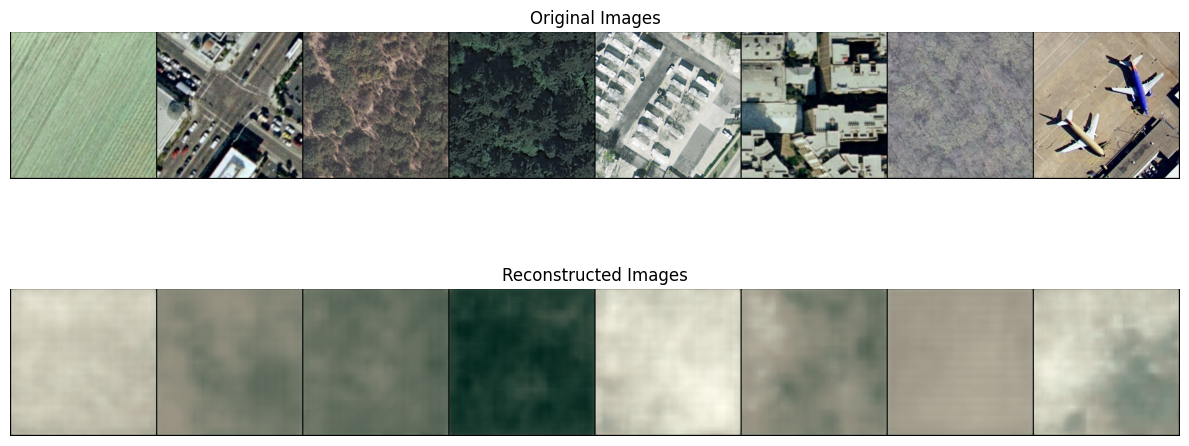


Epoch 151/1000
Current beta values: beta1=0.3020, beta2=0.3020


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.71it/s]


Train Loss: 5210.398958, Val Loss: 6106.048772
Train Recon: 5021.392156, KL1: 312.925170, KL2: 312.925170
Val Recon: 5904.715439, KL1: 333.333333, KL2: 333.333333
No improvement for 20 epochs

Epoch 152/1000
Current beta values: beta1=0.3040, beta2=0.3040


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.00it/s]


Train Loss: 5186.856229, Val Loss: 6071.606771
Train Recon: 4996.597731, KL1: 312.925170, KL2: 312.925170
Val Recon: 5868.940104, KL1: 333.333333, KL2: 333.333333
No improvement for 21 epochs

Epoch 153/1000
Current beta values: beta1=0.3060, beta2=0.3060


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.67it/s]


Train Loss: 5102.461012, Val Loss: 6115.165848
Train Recon: 4910.950803, KL1: 312.925170, KL2: 312.925170
Val Recon: 5911.165848, KL1: 333.333333, KL2: 333.333333
No improvement for 22 epochs

Epoch 154/1000
Current beta values: beta1=0.3080, beta2=0.3080


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.35it/s]


Train Loss: 5078.287872, Val Loss: 6086.533780
Train Recon: 4885.525978, KL1: 312.925170, KL2: 312.925170
Val Recon: 5881.200446, KL1: 333.333333, KL2: 333.333333
No improvement for 23 epochs

Epoch 155/1000
Current beta values: beta1=0.3100, beta2=0.3100


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.11it/s]


Train Loss: 5077.710496, Val Loss: 6128.267113
Train Recon: 4883.696896, KL1: 312.925170, KL2: 312.925170
Val Recon: 5921.600446, KL1: 333.333333, KL2: 333.333333
No improvement for 24 epochs

Epoch 156/1000
Current beta values: beta1=0.3120, beta2=0.3120


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.50it/s]


Train Loss: 5089.671535, Val Loss: 6155.303051
Train Recon: 4894.406223, KL1: 312.925170, KL2: 312.925170
Val Recon: 5947.303051, KL1: 333.333333, KL2: 333.333333
No improvement for 25 epochs

Epoch 157/1000
Current beta values: beta1=0.3140, beta2=0.3140


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.02it/s]


Train Loss: 5060.435613, Val Loss: 6146.940997
Train Recon: 4863.918612, KL1: 312.925170, KL2: 312.925170
Val Recon: 5937.607664, KL1: 333.333333, KL2: 333.333333
No improvement for 26 epochs

Epoch 158/1000
Current beta values: beta1=0.3160, beta2=0.3160


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.93it/s]


Train Loss: 5016.239015, Val Loss: 6138.779427
Train Recon: 4818.470302, KL1: 312.925170, KL2: 312.925170
Val Recon: 5928.112760, KL1: 333.333333, KL2: 333.333333
No improvement for 27 epochs

Epoch 159/1000
Current beta values: beta1=0.3180, beta2=0.3180


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


Train Loss: 5033.541348, Val Loss: 6163.701711
Train Recon: 4834.520940, KL1: 312.925170, KL2: 312.925170
Val Recon: 5951.701711, KL1: 333.333333, KL2: 333.333333
No improvement for 28 epochs

Epoch 160/1000
Current beta values: beta1=0.3200, beta2=0.3200


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.25it/s]


Train Loss: 5038.919218, Val Loss: 6334.685193
Train Recon: 4838.647109, KL1: 312.925170, KL2: 312.925170
Val Recon: 6121.351860, KL1: 333.333333, KL2: 333.333333
No improvement for 29 epochs

Epoch 161/1000
Current beta values: beta1=0.3220, beta2=0.3220


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.62it/s]


Train Loss: 5093.406734, Val Loss: 6205.517336
Train Recon: 4891.882924, KL1: 312.925170, KL2: 312.925170
Val Recon: 5990.850670, KL1: 333.333333, KL2: 333.333333
No improvement for 30 epochs

Epoch 162/1000
Current beta values: beta1=0.3240, beta2=0.3240


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.50it/s]


Train Loss: 5026.470716, Val Loss: 6368.183445
Train Recon: 4823.695206, KL1: 312.925170, KL2: 312.925170
Val Recon: 6152.183445, KL1: 333.333333, KL2: 333.333333
No improvement for 31 epochs

Epoch 163/1000
Current beta values: beta1=0.3260, beta2=0.3260


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.37it/s]


Train Loss: 5034.851796, Val Loss: 6477.417597
Train Recon: 4830.824585, KL1: 312.925170, KL2: 312.925170
Val Recon: 6260.084263, KL1: 333.333333, KL2: 333.333333
No improvement for 32 epochs

Epoch 164/1000
Current beta values: beta1=0.3280, beta2=0.3280


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.38it/s]


Train Loss: 5516.710906, Val Loss: 6396.463170
Train Recon: 5311.431994, KL1: 312.925170, KL2: 312.925170
Val Recon: 6177.796503, KL1: 333.333333, KL2: 333.333333
No improvement for 33 epochs

Epoch 165/1000
Current beta values: beta1=0.3300, beta2=0.3300


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.64it/s]


Train Loss: 5553.555017, Val Loss: 6847.482254
Train Recon: 5347.024399, KL1: 312.925170, KL2: 312.925170
Val Recon: 6627.482254, KL1: 333.333333, KL2: 333.333333
No improvement for 34 epochs

Epoch 166/1000
Current beta values: beta1=0.3320, beta2=0.3320


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.93it/s]


Train Loss: 5530.365418, Val Loss: 6300.019606
Train Recon: 5322.583105, KL1: 312.925170, KL2: 312.925170
Val Recon: 6078.686272, KL1: 333.333333, KL2: 333.333333
No improvement for 35 epochs

Epoch 167/1000
Current beta values: beta1=0.3340, beta2=0.3340


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


Train Loss: 5279.065657, Val Loss: 6480.440327
Train Recon: 5070.031638, KL1: 312.925170, KL2: 312.925170
Val Recon: 6257.773661, KL1: 333.333333, KL2: 333.333333
No improvement for 36 epochs

Epoch 168/1000
Current beta values: beta1=0.3360, beta2=0.3360


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.55it/s]


Train Loss: 5247.202041, Val Loss: 6247.381324
Train Recon: 5036.916332, KL1: 312.925170, KL2: 312.925170
Val Recon: 6023.381324, KL1: 333.333333, KL2: 333.333333
No improvement for 37 epochs

Epoch 169/1000
Current beta values: beta1=0.3380, beta2=0.3380


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.58it/s]


Train Loss: 5211.861065, Val Loss: 6253.397470
Train Recon: 5000.323650, KL1: 312.925170, KL2: 312.925170
Val Recon: 6028.064137, KL1: 333.333333, KL2: 333.333333
No improvement for 38 epochs

Epoch 170/1000
Current beta values: beta1=0.3400, beta2=0.3400


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.19it/s]


Train Loss: 5167.178848, Val Loss: 6194.142336
Train Recon: 4954.389732, KL1: 312.925170, KL2: 312.925170
Val Recon: 5967.475670, KL1: 333.333333, KL2: 333.333333
No improvement for 39 epochs

Epoch 171/1000
Current beta values: beta1=0.3420, beta2=0.3420


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.55it/s]


Train Loss: 5116.674479, Val Loss: 6287.882217
Train Recon: 4902.633663, KL1: 312.925170, KL2: 312.925170
Val Recon: 6059.882217, KL1: 333.333333, KL2: 333.333333
No improvement for 40 epochs

Epoch 172/1000
Current beta values: beta1=0.3440, beta2=0.3440


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.38it/s]


Train Loss: 5161.181277, Val Loss: 6243.811868
Train Recon: 4945.888760, KL1: 312.925170, KL2: 312.925170
Val Recon: 6014.478534, KL1: 333.333333, KL2: 333.333333
No improvement for 41 epochs

Epoch 173/1000
Current beta values: beta1=0.3460, beta2=0.3460


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.03it/s]


Train Loss: 5123.063026, Val Loss: 6561.006362
Train Recon: 4906.518814, KL1: 312.925170, KL2: 312.925170
Val Recon: 6330.339695, KL1: 333.333333, KL2: 333.333333
No improvement for 42 epochs

Epoch 174/1000
Current beta values: beta1=0.3480, beta2=0.3480


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.41it/s]


Train Loss: 5062.314913, Val Loss: 6341.737574
Train Recon: 4844.518994, KL1: 312.925170, KL2: 312.925170
Val Recon: 6109.737574, KL1: 333.333333, KL2: 333.333333
No improvement for 43 epochs

Epoch 175/1000
Current beta values: beta1=0.3500, beta2=0.3500


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.86it/s]


Train Loss: 5036.282504, Val Loss: 7419.720164
Train Recon: 4817.234885, KL1: 312.925170, KL2: 312.925170
Val Recon: 7186.386830, KL1: 333.333333, KL2: 333.333333
No improvement for 44 epochs

Epoch 176/1000
Current beta values: beta1=0.3520, beta2=0.3520


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.49it/s]


Train Loss: 4993.190141, Val Loss: 6307.331436
Train Recon: 4772.890822, KL1: 312.925170, KL2: 312.925170
Val Recon: 6072.664769, KL1: 333.333333, KL2: 333.333333
No improvement for 45 epochs

Epoch 177/1000
Current beta values: beta1=0.3540, beta2=0.3540


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.61it/s]


Train Loss: 5005.477934, Val Loss: 6341.037649
Train Recon: 4783.926908, KL1: 312.925170, KL2: 312.925170
Val Recon: 6105.037649, KL1: 333.333333, KL2: 333.333333
No improvement for 46 epochs

Epoch 178/1000
Current beta values: beta1=0.3560, beta2=0.3560


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.20it/s]


Train Loss: 5017.330198, Val Loss: 6309.606771
Train Recon: 4794.527477, KL1: 312.925170, KL2: 312.925170
Val Recon: 6072.273438, KL1: 333.333333, KL2: 333.333333
No improvement for 47 epochs

Epoch 179/1000
Current beta values: beta1=0.3580, beta2=0.3580


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.17it/s]


Train Loss: 4969.529406, Val Loss: 6344.511979
Train Recon: 4745.474989, KL1: 312.925170, KL2: 312.925170
Val Recon: 6105.845312, KL1: 333.333333, KL2: 333.333333
No improvement for 48 epochs

Epoch 180/1000
Current beta values: beta1=0.3600, beta2=0.3600


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.07it/s]

Train Loss: 4965.884003, Val Loss: 6356.166481
Train Recon: 4740.577870, KL1: 312.925170, KL2: 312.925170
Val Recon: 6116.166481, KL1: 333.333333, KL2: 333.333333
No improvement for 49 epochs


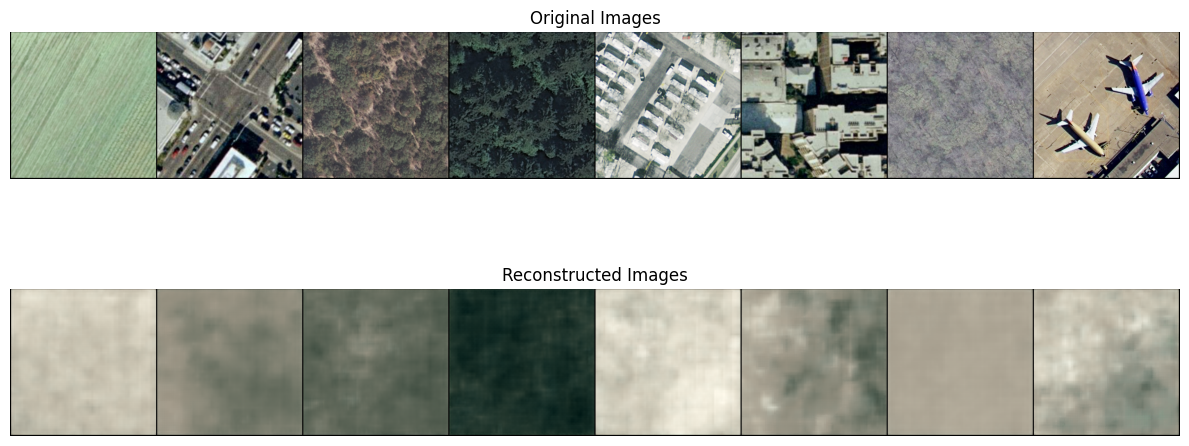


Epoch 181/1000
Current beta values: beta1=0.3620, beta2=0.3620


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.46it/s]


Train Loss: 4988.190444, Val Loss: 6355.498958
Train Recon: 4761.632621, KL1: 312.925170, KL2: 312.925170
Val Recon: 6114.165625, KL1: 333.333333, KL2: 333.333333
No improvement for 50 epochs

Epoch 182/1000
Current beta values: beta1=0.3640, beta2=0.3640


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.40it/s]


Train Loss: 4941.534673, Val Loss: 6375.601376
Train Recon: 4713.725159, KL1: 312.925170, KL2: 312.925170
Val Recon: 6132.934710, KL1: 333.333333, KL2: 333.333333
No improvement for 51 epochs

Epoch 183/1000
Current beta values: beta1=0.3660, beta2=0.3660


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.77it/s]


Train Loss: 4952.348926, Val Loss: 6310.007440
Train Recon: 4723.287702, KL1: 312.925170, KL2: 312.925170
Val Recon: 6066.007440, KL1: 333.333333, KL2: 333.333333
No improvement for 52 epochs

Epoch 184/1000
Current beta values: beta1=0.3680, beta2=0.3680


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.48it/s]


Train Loss: 4969.747991, Val Loss: 6459.953646
Train Recon: 4739.435071, KL1: 312.925170, KL2: 312.925170
Val Recon: 6214.620313, KL1: 333.333333, KL2: 333.333333
No improvement for 53 epochs

Epoch 185/1000
Current beta values: beta1=0.3700, beta2=0.3700


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.56it/s]


Train Loss: 4932.546328, Val Loss: 6362.306957
Train Recon: 4700.981707, KL1: 312.925170, KL2: 312.925170
Val Recon: 6115.640290, KL1: 333.333333, KL2: 333.333333
No improvement for 54 epochs

Epoch 186/1000
Current beta values: beta1=0.3720, beta2=0.3720


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.70it/s]


Train Loss: 4904.693038, Val Loss: 6369.237798
Train Recon: 4671.876711, KL1: 312.925170, KL2: 312.925170
Val Recon: 6121.237798, KL1: 333.333333, KL2: 333.333333
No improvement for 55 epochs

Epoch 187/1000
Current beta values: beta1=0.3740, beta2=0.3740


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.16it/s]


Train Loss: 4945.507903, Val Loss: 6437.137016
Train Recon: 4711.439876, KL1: 312.925170, KL2: 312.925170
Val Recon: 6187.803683, KL1: 333.333333, KL2: 333.333333
No improvement for 56 epochs

Epoch 188/1000
Current beta values: beta1=0.3760, beta2=0.3760


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.00it/s]


Train Loss: 4927.091922, Val Loss: 6401.743304
Train Recon: 4691.772205, KL1: 312.925170, KL2: 312.925170
Val Recon: 6151.076637, KL1: 333.333333, KL2: 333.333333
No improvement for 57 epochs

Epoch 189/1000
Current beta values: beta1=0.3780, beta2=0.3780


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.20it/s]


Train Loss: 4908.276749, Val Loss: 6392.824107
Train Recon: 4671.705320, KL1: 312.925170, KL2: 312.925170
Val Recon: 6140.824107, KL1: 333.333333, KL2: 333.333333
No improvement for 58 epochs

Epoch 190/1000
Current beta values: beta1=0.3800, beta2=0.3800


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.14it/s]


Train Loss: 4858.692761, Val Loss: 6426.734821
Train Recon: 4620.869627, KL1: 312.925170, KL2: 312.925170
Val Recon: 6173.401488, KL1: 333.333333, KL2: 333.333333
No improvement for 59 epochs

Epoch 191/1000
Current beta values: beta1=0.3820, beta2=0.3820


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.18it/s]


Train Loss: 4850.894441, Val Loss: 6404.485714
Train Recon: 4611.819611, KL1: 312.925170, KL2: 312.925170
Val Recon: 6149.819048, KL1: 333.333333, KL2: 333.333333
No improvement for 60 epochs

Epoch 192/1000
Current beta values: beta1=0.3840, beta2=0.3840


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.32it/s]


Train Loss: 4863.248273, Val Loss: 6424.261830
Train Recon: 4622.921732, KL1: 312.925170, KL2: 312.925170
Val Recon: 6168.261830, KL1: 333.333333, KL2: 333.333333
No improvement for 61 epochs

Epoch 193/1000
Current beta values: beta1=0.3860, beta2=0.3860


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.46it/s]


Train Loss: 4848.243277, Val Loss: 6420.586719
Train Recon: 4606.665046, KL1: 312.925170, KL2: 312.925170
Val Recon: 6163.253385, KL1: 333.333333, KL2: 333.333333
No improvement for 62 epochs

Epoch 194/1000
Current beta values: beta1=0.3880, beta2=0.3880


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.85it/s]


Train Loss: 4802.587739, Val Loss: 6480.234598
Train Recon: 4559.757802, KL1: 312.925170, KL2: 312.925170
Val Recon: 6221.567932, KL1: 333.333333, KL2: 333.333333
No improvement for 63 epochs

Epoch 195/1000
Current beta values: beta1=0.3900, beta2=0.3900


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.43it/s]


Train Loss: 4818.945993, Val Loss: 6490.307254
Train Recon: 4574.864365, KL1: 312.925170, KL2: 312.925170
Val Recon: 6230.307254, KL1: 333.333333, KL2: 333.333333
No improvement for 64 epochs

Epoch 196/1000
Current beta values: beta1=0.3920, beta2=0.3920


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.05it/s]


Train Loss: 4752.907212, Val Loss: 6480.212984
Train Recon: 4507.573884, KL1: 312.925170, KL2: 312.925170
Val Recon: 6218.879650, KL1: 333.333333, KL2: 333.333333
No improvement for 65 epochs

Epoch 197/1000
Current beta values: beta1=0.3940, beta2=0.3940


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.00it/s]


Train Loss: 4777.849676, Val Loss: 6527.208259
Train Recon: 4531.264642, KL1: 312.925170, KL2: 312.925170
Val Recon: 6264.541592, KL1: 333.333333, KL2: 333.333333
No improvement for 66 epochs

Epoch 198/1000
Current beta values: beta1=0.3960, beta2=0.3960


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.90it/s]


Train Loss: 4765.145642, Val Loss: 6553.537463
Train Recon: 4517.308918, KL1: 312.925170, KL2: 312.925170
Val Recon: 6289.537463, KL1: 333.333333, KL2: 333.333333
No improvement for 67 epochs

Epoch 199/1000
Current beta values: beta1=0.3980, beta2=0.3980


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.65it/s]


Train Loss: 4792.080506, Val Loss: 6526.104092
Train Recon: 4542.992071, KL1: 312.925170, KL2: 312.925170
Val Recon: 6260.770759, KL1: 333.333333, KL2: 333.333333
No improvement for 68 epochs

Epoch 200/1000
Current beta values: beta1=0.4000, beta2=0.4000


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.09it/s]


Train Loss: 4791.469207, Val Loss: 6510.716146
Train Recon: 4541.129071, KL1: 312.925170, KL2: 312.925170
Val Recon: 6244.049479, KL1: 333.333333, KL2: 333.333333
No improvement for 69 epochs

Epoch 201/1000
Current beta values: beta1=0.4020, beta2=0.4020


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.78it/s]


Train Loss: 4800.252865, Val Loss: 6501.720833
Train Recon: 4548.661033, KL1: 312.925170, KL2: 312.925170
Val Recon: 6233.720833, KL1: 333.333333, KL2: 333.333333
No improvement for 70 epochs

Epoch 202/1000
Current beta values: beta1=0.4040, beta2=0.4040


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.74it/s]


Train Loss: 4758.283126, Val Loss: 6529.201823
Train Recon: 4505.439567, KL1: 312.925170, KL2: 312.925170
Val Recon: 6259.868490, KL1: 333.333333, KL2: 333.333333
No improvement for 71 epochs

Epoch 203/1000
Current beta values: beta1=0.4060, beta2=0.4060


Validation: 100%|██████████| 7/7 [00:00<00:00, 17.11it/s]


Train Loss: 4772.703300, Val Loss: 6565.736607
Train Recon: 4518.608068, KL1: 312.925170, KL2: 312.925170
Val Recon: 6295.069940, KL1: 333.333333, KL2: 333.333333
No improvement for 72 epochs

Epoch 204/1000
Current beta values: beta1=0.4080, beta2=0.4080


Validation: 100%|██████████| 7/7 [00:00<00:00, 18.81it/s]


Train Loss: 4764.242591, Val Loss: 6517.787723
Train Recon: 4508.895647, KL1: 312.925170, KL2: 312.925170
Val Recon: 6245.787723, KL1: 333.333333, KL2: 333.333333
No improvement for 73 epochs

Epoch 205/1000
Current beta values: beta1=0.4100, beta2=0.4100


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.75it/s]


Train Loss: 4773.538143, Val Loss: 6530.958408
Train Recon: 4516.939493, KL1: 312.925170, KL2: 312.925170
Val Recon: 6257.625074, KL1: 333.333333, KL2: 333.333333
No improvement for 74 epochs

Epoch 206/1000
Current beta values: beta1=0.4120, beta2=0.4120


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.21it/s]


Train Loss: 4778.698507, Val Loss: 6606.703051
Train Recon: 4520.848166, KL1: 312.925170, KL2: 312.925170
Val Recon: 6332.036384, KL1: 333.333333, KL2: 333.333333
No improvement for 75 epochs

Epoch 207/1000
Current beta values: beta1=0.4140, beta2=0.4140


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.07it/s]


Train Loss: 4733.279337, Val Loss: 6637.235937
Train Recon: 4474.177296, KL1: 312.925170, KL2: 312.925170
Val Recon: 6361.235937, KL1: 333.333333, KL2: 333.333333
No improvement for 76 epochs

Epoch 208/1000
Current beta values: beta1=0.4160, beta2=0.4160


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.75it/s]


Train Loss: 4725.148305, Val Loss: 6542.696131
Train Recon: 4464.794568, KL1: 312.925170, KL2: 312.925170
Val Recon: 6265.362798, KL1: 333.333333, KL2: 333.333333
No improvement for 77 epochs

Epoch 209/1000
Current beta values: beta1=0.4180, beta2=0.4180


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.48it/s]


Train Loss: 4749.625367, Val Loss: 6579.136830
Train Recon: 4488.019925, KL1: 312.925170, KL2: 312.925170
Val Recon: 6300.470164, KL1: 333.333333, KL2: 333.333333
No improvement for 78 epochs

Epoch 210/1000
Current beta values: beta1=0.4200, beta2=0.4200


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.18it/s]

Train Loss: 4749.281819, Val Loss: 6600.962798
Train Recon: 4486.424676, KL1: 312.925170, KL2: 312.925170
Val Recon: 6320.962798, KL1: 333.333333, KL2: 333.333333
No improvement for 79 epochs


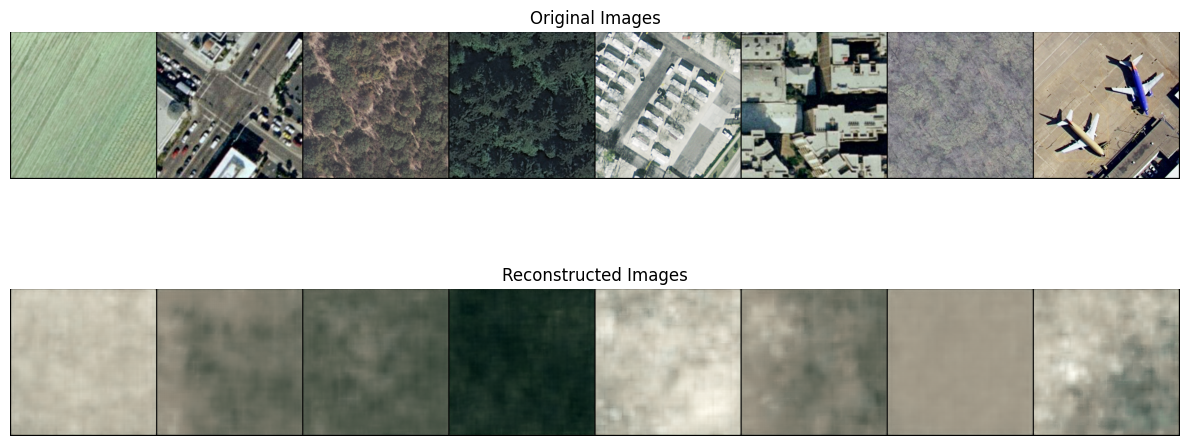


Epoch 211/1000
Current beta values: beta1=0.4220, beta2=0.4220


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.50it/s]


Train Loss: 4691.219483, Val Loss: 6600.944643
Train Recon: 4427.110635, KL1: 312.925170, KL2: 312.925170
Val Recon: 6319.611310, KL1: 333.333333, KL2: 333.333333
No improvement for 80 epochs

Epoch 212/1000
Current beta values: beta1=0.4240, beta2=0.4240


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.05it/s]


Train Loss: 4742.280251, Val Loss: 6546.675967
Train Recon: 4476.919723, KL1: 312.925170, KL2: 312.925170
Val Recon: 6264.009301, KL1: 333.333333, KL2: 333.333333
No improvement for 81 epochs

Epoch 213/1000
Current beta values: beta1=0.4260, beta2=0.4260


Validation: 100%|██████████| 7/7 [00:00<00:00, 21.15it/s]


Train Loss: 4702.770876, Val Loss: 6589.747173
Train Recon: 4436.158626, KL1: 312.925170, KL2: 312.925170
Val Recon: 6305.747173, KL1: 333.333333, KL2: 333.333333
No improvement for 82 epochs

Epoch 214/1000
Current beta values: beta1=0.4280, beta2=0.4280


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.28it/s]


Train Loss: 4701.430261, Val Loss: 6556.644754
Train Recon: 4433.566332, KL1: 312.925170, KL2: 312.925170
Val Recon: 6271.311421, KL1: 333.333333, KL2: 333.333333
No improvement for 83 epochs

Epoch 215/1000
Current beta values: beta1=0.4300, beta2=0.4300


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.16it/s]


Train Loss: 4677.792193, Val Loss: 6650.870275
Train Recon: 4408.676547, KL1: 312.925170, KL2: 312.925170
Val Recon: 6364.203609, KL1: 333.333333, KL2: 333.333333
No improvement for 84 epochs

Epoch 216/1000
Current beta values: beta1=0.4320, beta2=0.4320


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.25it/s]


Train Loss: 4706.384099, Val Loss: 6675.048698
Train Recon: 4436.016746, KL1: 312.925170, KL2: 312.925170
Val Recon: 6387.048698, KL1: 333.333333, KL2: 333.333333
No improvement for 85 epochs

Epoch 217/1000
Current beta values: beta1=0.4340, beta2=0.4340


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.74it/s]


Train Loss: 4666.054544, Val Loss: 6679.499628
Train Recon: 4394.435496, KL1: 312.925170, KL2: 312.925170
Val Recon: 6390.166295, KL1: 333.333333, KL2: 333.333333
No improvement for 86 epochs

Epoch 218/1000
Current beta values: beta1=0.4360, beta2=0.4360


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.86it/s]


Train Loss: 4631.422279, Val Loss: 6592.106436
Train Recon: 4358.551531, KL1: 312.925170, KL2: 312.925170
Val Recon: 6301.439769, KL1: 333.333333, KL2: 333.333333
No improvement for 87 epochs

Epoch 219/1000
Current beta values: beta1=0.4380, beta2=0.4380


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.57it/s]


Train Loss: 4662.662197, Val Loss: 6623.115402
Train Recon: 4388.539753, KL1: 312.925170, KL2: 312.925170
Val Recon: 6331.115402, KL1: 333.333333, KL2: 333.333333
No improvement for 88 epochs

Epoch 220/1000
Current beta values: beta1=0.4400, beta2=0.4400


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.21it/s]


Train Loss: 4669.678768, Val Loss: 6617.257217
Train Recon: 4394.304640, KL1: 312.925170, KL2: 312.925170
Val Recon: 6323.923884, KL1: 333.333333, KL2: 333.333333
No improvement for 89 epochs

Epoch 221/1000
Current beta values: beta1=0.4420, beta2=0.4420


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.30it/s]


Train Loss: 4649.934673, Val Loss: 6654.580655
Train Recon: 4373.308822, KL1: 312.925170, KL2: 312.925170
Val Recon: 6359.913988, KL1: 333.333333, KL2: 333.333333
No improvement for 90 epochs

Epoch 222/1000
Current beta values: beta1=0.4440, beta2=0.4440


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.28it/s]


Train Loss: 4664.949490, Val Loss: 6669.563430
Train Recon: 4387.071944, KL1: 312.925170, KL2: 312.925170
Val Recon: 6373.563430, KL1: 333.333333, KL2: 333.333333
No improvement for 91 epochs

Epoch 223/1000
Current beta values: beta1=0.4460, beta2=0.4460


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.29it/s]


Train Loss: 4621.805984, Val Loss: 6662.969122
Train Recon: 4342.676738, KL1: 312.925170, KL2: 312.925170
Val Recon: 6365.635789, KL1: 333.333333, KL2: 333.333333
No improvement for 92 epochs

Epoch 224/1000
Current beta values: beta1=0.4480, beta2=0.4480


Validation: 100%|██████████| 7/7 [00:00<00:00, 19.81it/s]


Train Loss: 4618.392118, Val Loss: 6671.128906
Train Recon: 4338.011161, KL1: 312.925170, KL2: 312.925170
Val Recon: 6372.462240, KL1: 333.333333, KL2: 333.333333
No improvement for 93 epochs

Epoch 225/1000
Current beta values: beta1=0.4500, beta2=0.4500


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.93it/s]


Train Loss: 4598.831319, Val Loss: 6703.998289
Train Recon: 4317.198661, KL1: 312.925170, KL2: 312.925170
Val Recon: 6403.998289, KL1: 333.333333, KL2: 333.333333
No improvement for 94 epochs

Epoch 226/1000
Current beta values: beta1=0.4520, beta2=0.4520


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.33it/s]


Train Loss: 4580.868979, Val Loss: 6689.688393
Train Recon: 4297.984625, KL1: 312.925170, KL2: 312.925170
Val Recon: 6388.355060, KL1: 333.333333, KL2: 333.333333
No improvement for 95 epochs

Epoch 227/1000
Current beta values: beta1=0.4540, beta2=0.4540


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.16it/s]


Train Loss: 4647.511336, Val Loss: 6665.171429
Train Recon: 4363.375266, KL1: 312.925170, KL2: 312.925170
Val Recon: 6362.504762, KL1: 333.333333, KL2: 333.333333
No improvement for 96 epochs

Epoch 228/1000
Current beta values: beta1=0.4560, beta2=0.4560


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.96it/s]


Train Loss: 4657.106463, Val Loss: 6710.817411
Train Recon: 4371.718707, KL1: 312.925170, KL2: 312.925170
Val Recon: 6406.817411, KL1: 333.333333, KL2: 333.333333
No improvement for 97 epochs

Epoch 229/1000
Current beta values: beta1=0.4580, beta2=0.4580


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.81it/s]


Train Loss: 4661.671184, Val Loss: 6725.901711
Train Recon: 4375.031723, KL1: 312.925170, KL2: 312.925170
Val Recon: 6420.568378, KL1: 333.333333, KL2: 333.333333
No improvement for 98 epochs

Epoch 230/1000
Current beta values: beta1=0.4600, beta2=0.4600


Validation: 100%|██████████| 7/7 [00:00<00:00, 17.05it/s]


Train Loss: 4656.577498, Val Loss: 6698.625707
Train Recon: 4368.686347, KL1: 312.925170, KL2: 312.925170
Val Recon: 6391.959040, KL1: 333.333333, KL2: 333.333333
No improvement for 99 epochs

Epoch 231/1000
Current beta values: beta1=0.4620, beta2=0.4620


Validation: 100%|██████████| 7/7 [00:00<00:00, 20.42it/s]


Train Loss: 4623.590274, Val Loss: 6692.300298
Train Recon: 4334.447417, KL1: 312.925170, KL2: 312.925170
Val Recon: 6384.300298, KL1: 333.333333, KL2: 333.333333
No improvement for 100 epochs
Early stopping after 231 epochs
Training complete in 6m 37s
Best validation loss: 5970.857515


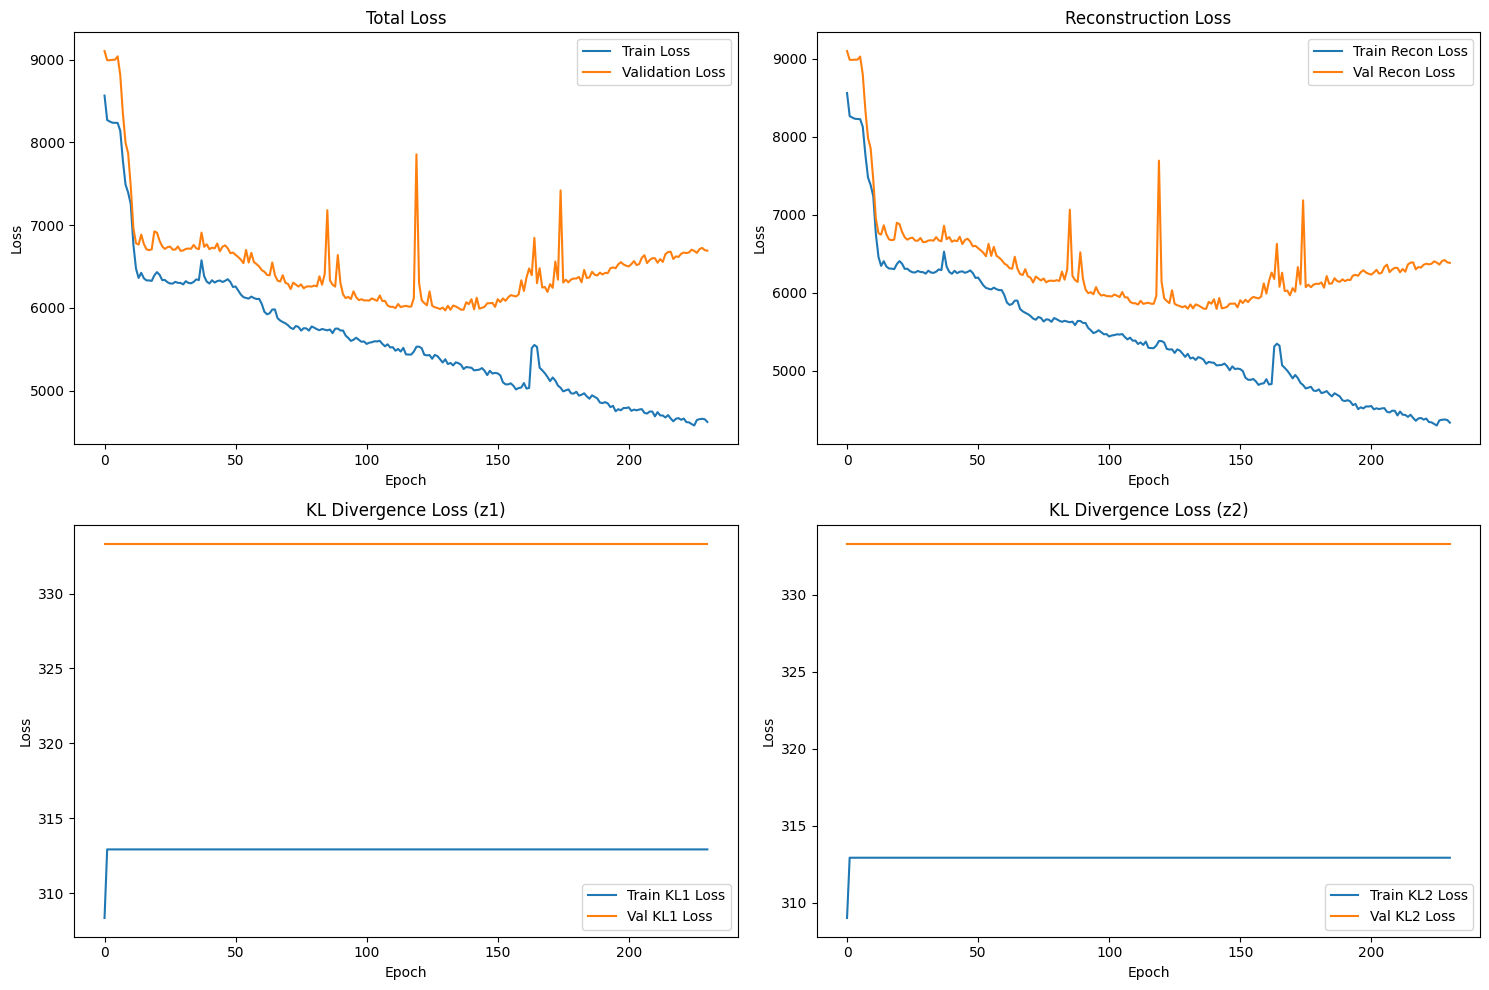

In [11]:
trained_model, history = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
    device=device, epochs=1000, lr=5e-3, early_stopping_patience=100, scheduler_patience=20, scheduler_factor=0.5)

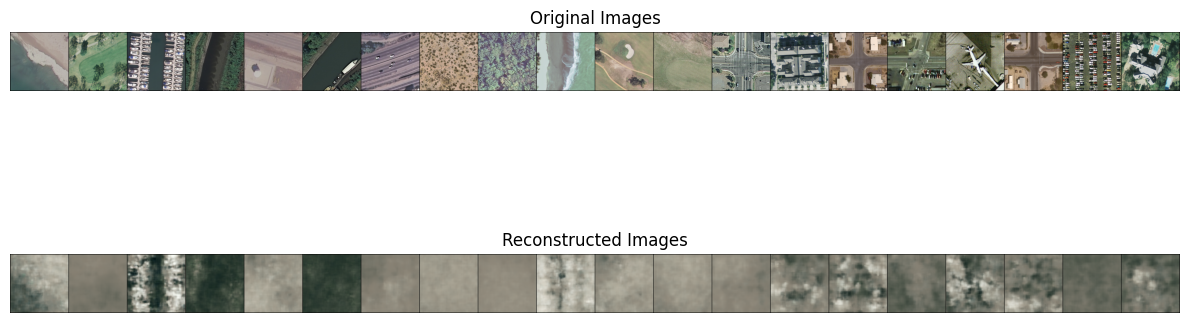

In [12]:
visualize_reconstructions(trained_model, test_loader, device, num_images=20)